In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

from f723.tools.dataset.features import NucleotideFeaturesExtractor
from f723.tools.urs.extraction import get_sec_struct_model, get_data
from f723.tools.models.application import ClassificationResult
from f723.tools.show.classification import show_classification_result

In [3]:
DATASET_DIR = '/home/mikhail/bioinformatics/data/dataset_all_60'
NRLIST_PATH = '/home/mikhail/bioinformatics/data/nrlist_3.76_3.0A.csv'
JSON_DIR = '/home/mikhail/bioinformatics/data/NR_3.0/json'
CIF_DIR = '/home/mikhail/bioinformatics/data/NR_3.0/cif/'
OUT_DIR = '/home/mikhail/bioinformatics/data/NR_3.0/out/'
SEC_STRUCT_DIR = '/home/mikhail/bioinformatics/data/sec_struct'

FEATURES_PATH = os.path.join(DATASET_DIR, 'features.npy')
TARGET_PATH = os.path.join(DATASET_DIR, 'target.npy')
GROUPS_PATH = os.path.join(DATASET_DIR, 'groups.npy')

PAIR_TYPES = ['ss_bps', 'noncanonical_bps', 'random']

Загрузим триплеты из цепочек, с которыми мы работаем.

In [4]:
with open('/home/mikhail/bioinformatics/data/chains_for_classification.json', 'r') as infile:
    chains_for_classification = json.load(infile)
    
pdb_ids = list({pdb_id for pdb_id, _ in chains_for_classification})

In [5]:
def load_triplets(pdb_ids):
    triplets = []
    
    for pdb_id in tqdm(pdb_ids):
        urs_model = get_sec_struct_model(SEC_STRUCT_DIR, pdb_id)
        
        for mult in urs_model.lumults:
            if mult['SIZE'] == 3:
                nucls = tuple(sorted([nucl[0] for nucl in mult['NUCLS']]))
                triplets.append((pdb_id, nucls))
    
    return triplets

In [6]:
triplets = load_triplets(pdb_ids)

100%|██████████| 341/341 [00:29<00:00, 41.67it/s]


Построим маппинг: пара -> индекс триплета

In [7]:
triplet_pairs = {}

for index, (pdb_id, nucls) in enumerate(triplets):
    for left_index, left in enumerate(nucls):
        right = nucls[(left_index + 1) % 3]
        
        triplet_pairs['#'.join([pdb_id, left, right])] = index
        triplet_pairs['#'.join([pdb_id, right, left])] = index

Ранее мы уже строили выборку, в которой были фичи и таргеты. Загрузим её и также для каждой пары посчитаем pdb_id + dssr_id её нуклеотидов, чтобы потом искать по триплетам. Также для каждой пары посчитаем pdb_id + chain_id, чтобы построить разбивку precision/recall/noncanonical_num по структурам.

In [8]:
def get_sample_pairs_and_chains():
    sample_pairs = []
    chains = []
    
    for pair in get_data(DATASET_DIR):
        sample_pairs.append('#'.join([pair.meta.pdb_id, pair.meta.pair.nt_left.id, pair.meta.pair.nt_right.id]))
        chains.append('#'.join([pair.meta.pdb_id, pair.meta.pair.nt_left.chain_id]))
    
    return np.repeat(sample_pairs, 2, axis=0), np.repeat(chains, 2, axis=0)

In [9]:
sample_pairs, chains = get_sample_pairs_and_chains()

100%|██████████| 30/30 [01:31<00:00,  2.99s/it]


In [10]:
FEATURES_SHAPE = (6830702, 465)

In [11]:
def load_features():
    features = np.memmap(FEATURES_PATH, shape=FEATURES_SHAPE)
    target = np.load(TARGET_PATH)
    pdb_ids = np.load(GROUPS_PATH)
    
    return features, target, pdb_ids

In [12]:
features, target, pdb_ids = load_features()

In [13]:
mask = target != 0  # throw away secondary structure pairs

features = features[mask]
target = target[mask]
pdb_ids = pdb_ids[mask]
sample_pairs = sample_pairs[mask]
chains = chains[mask]

Загрузим предсказания random forest

In [14]:
TARGET_PRED_PATH = os.path.join(DATASET_DIR, 'target_pred_5_splits_random_forest_n_extimators_100.npy')
TARGET_PRED_PROBA_PATH = os.path.join(DATASET_DIR, 'target_pred_proba_5_splits_random_forest_n_extimators_100.npy')

In [15]:
target_pred = np.load(TARGET_PRED_PATH)
target_proba = np.load(TARGET_PRED_PROBA_PATH)

In [16]:
classification_result = ClassificationResult(
    target=target == 1, predicted=target_pred == 1, predicted_proba=target_proba)

Нарисуем разные графики. Predict proba distribution -- как раз тот график распределения предсказанных вероятностей.

precision_recall_fscore_support
(array([0.99845966, 0.89888849]), array([0.9998754 , 0.41797266]), array([0.99916703, 0.57061568]), array([6789520,   17994]))


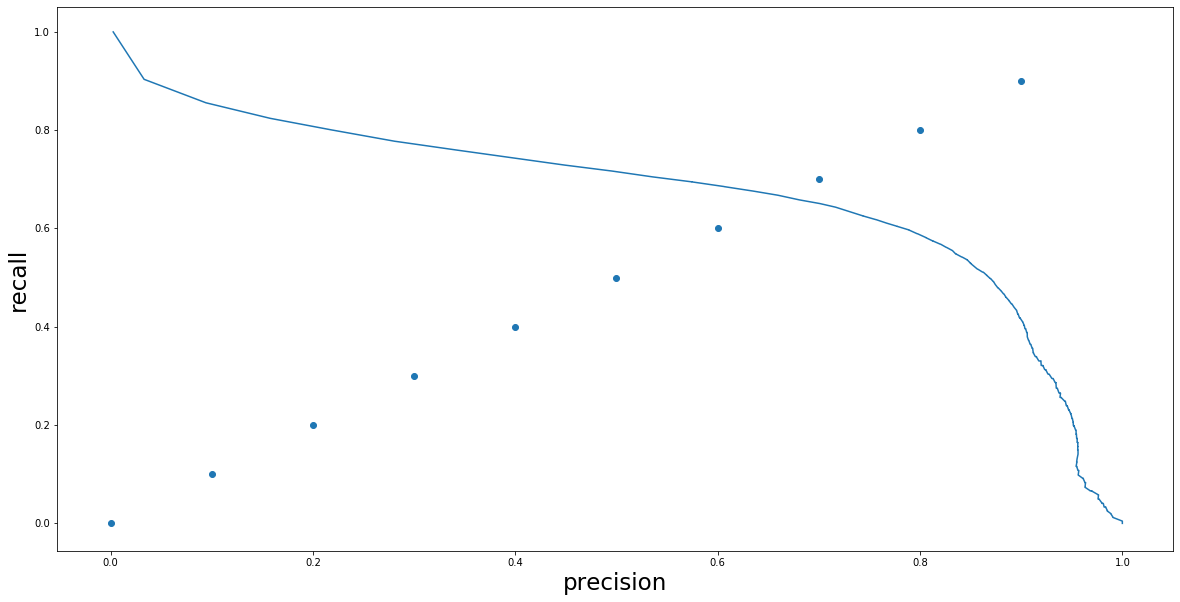

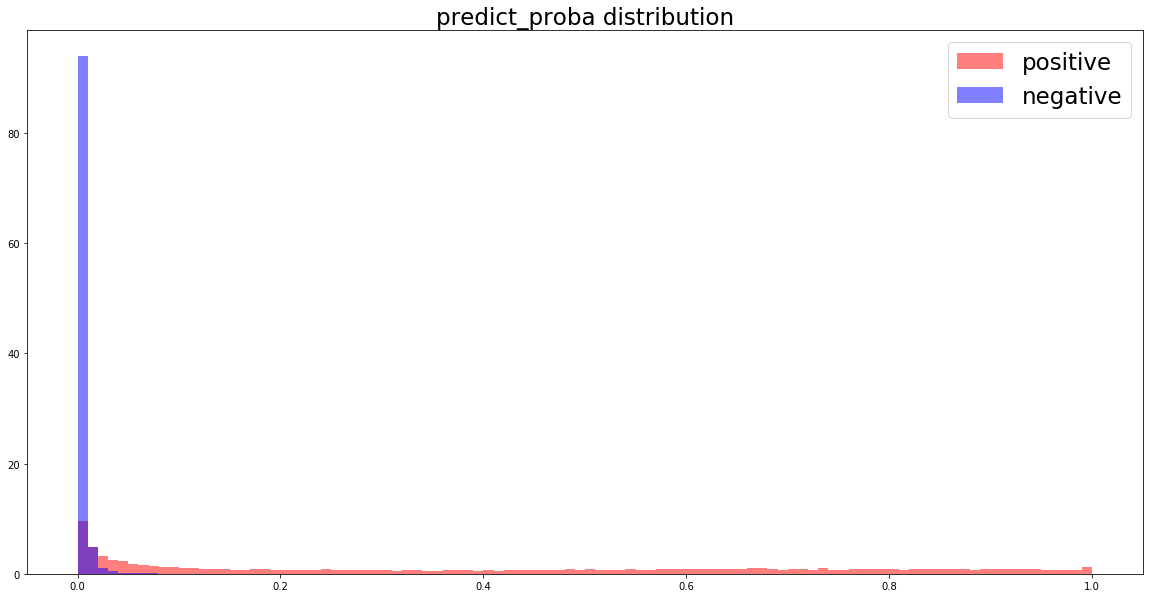

roc auc
0.9453347857360126


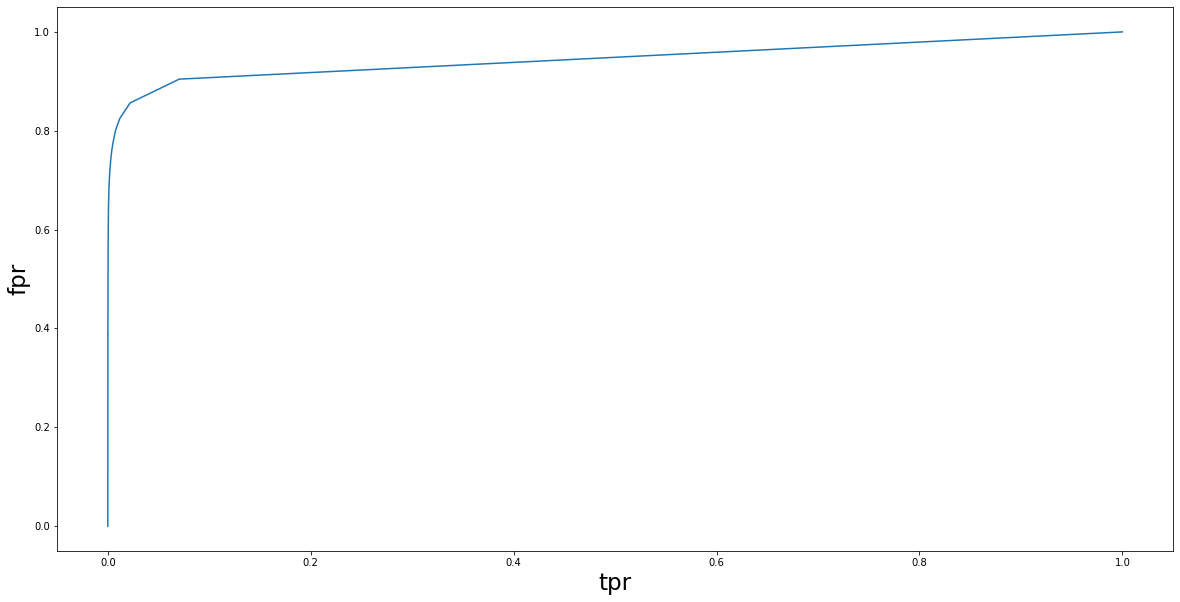

In [17]:
show_classification_result(classification_result)

Подберем threshold так, чтобы precision был около 0.8, тогда recall тоже будет приличным

In [87]:
precision, recall, thresholds = precision_recall_curve(
    classification_result.target, classification_result.predicted_proba)

index = np.argmin(np.abs(precision - 0.8))
threshold = thresholds[index]

precision[index], recall[index]

(0.7975483191697376, 0.5893631210403468)

In [89]:
new_pred = classification_result.predicted_proba > threshold

In [90]:
precision_recall_fscore_support(target == 1, new_pred)

(array([0.99889308, 0.80542952]),
 array([0.99962737, 0.58202734]),
 array([0.99926009, 0.67574281]),
 array([6789520,   17994]))

In [91]:
true_positive_mask = (target == 1) & new_pred
false_negative_mask = (target == 1) & ~new_pred

Посчитаем  
1) Процент триплетов, в которых есть хотя бы одна пара из заданного множества  
2) Процент пар в заданном множестве, участвующих хотя бы в одном триплете  

Множества -- это false negative и true positive

In [92]:
def process_stats(mask):
    triplets_in_mask = {triplet_pairs[pair] for pair in sample_pairs[mask] if pair in triplet_pairs}
    percentage_triplets_in_mask = len(triplets_in_mask) / len(triplets)
    percentage_mask_in_triplets = np.mean([pair in triplet_pairs for pair in sample_pairs[mask]])
    
    return percentage_triplets_in_mask, percentage_mask_in_triplets

In [93]:
process_stats(true_positive_mask)

(0.12934286281516777, 0.3227346510073522)

In [94]:
process_stats(false_negative_mask)

(0.09718086162398253, 0.3199042680494615)

Статистики почти не отличаются для false negative и true positive. Вывод: классификация никак не скоррелирована с распределением нуклеотидов по триплетам

Сравним распределение fragment_length, fragment_index по разным нуклеотидам в фичах для true_positive и false_negative

In [81]:
SECONDARY_STRUCTURES = ['BC', 'BI', 'BP', 'HC', 'HI', 'HP', 'IC', 'II', 'IP', 'JC', 'JI', 'JP', 'S']
BASES = ['a', 'u', 'g', 'c']
NUCLEOTIDE_FEATURES_LEN = 1 + len(SECONDARY_STRUCTURES) + len(BASES) + 1 + 2

FRAGMENT_LENGTH_OFFSET = len(SECONDARY_STRUCTURES) + len(BASES) + 2
FRAGMENT_INDEX_OFFSET = FRAGMENT_LENGTH_OFFSET + 1

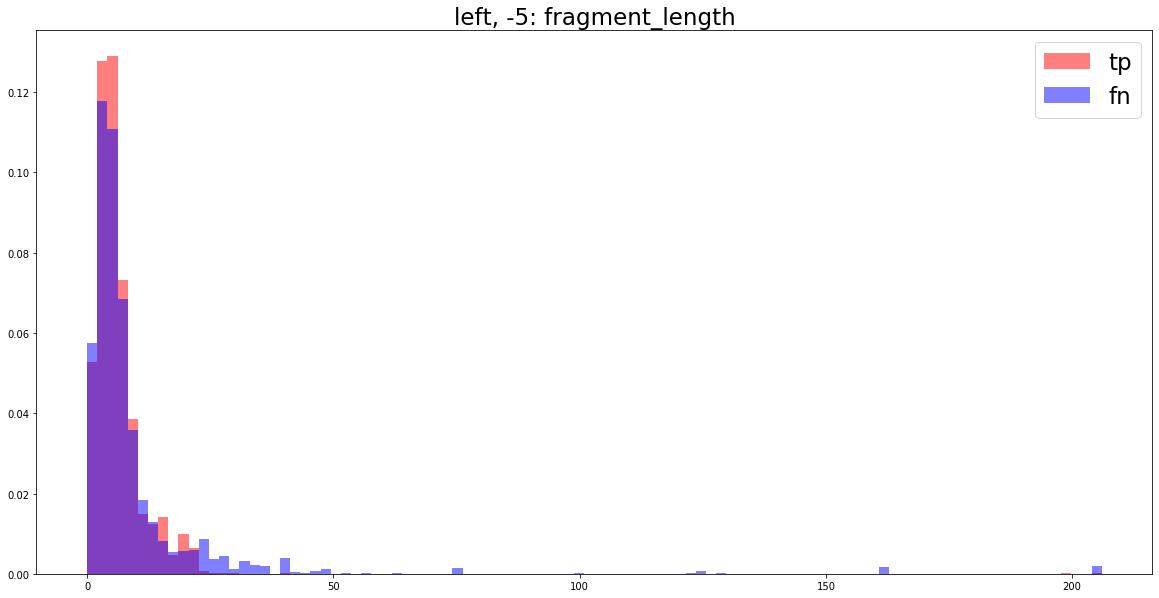

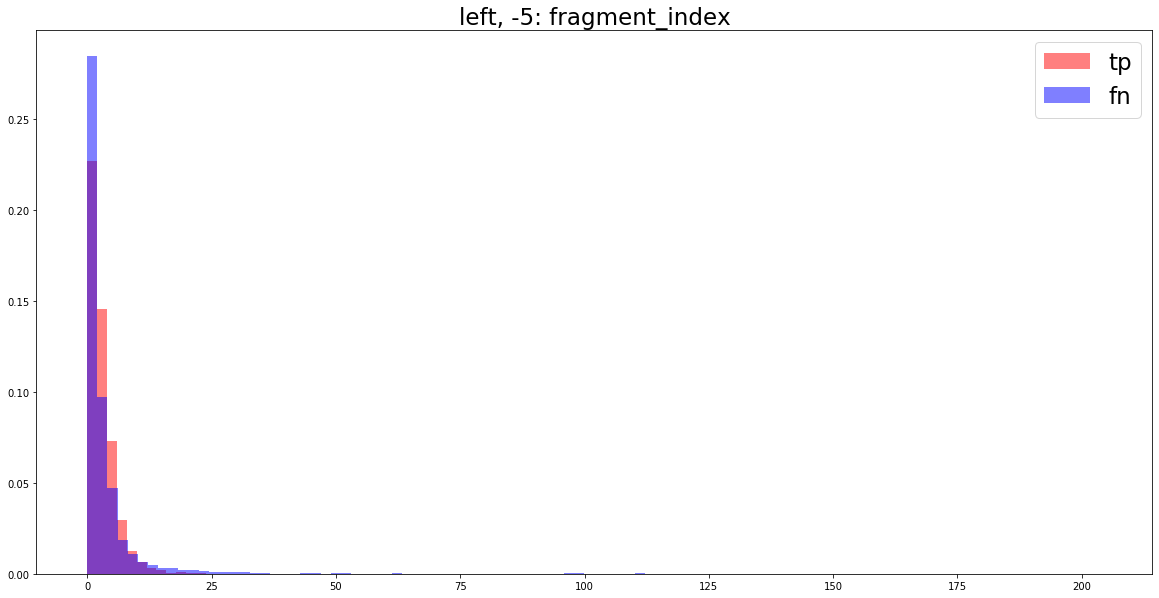

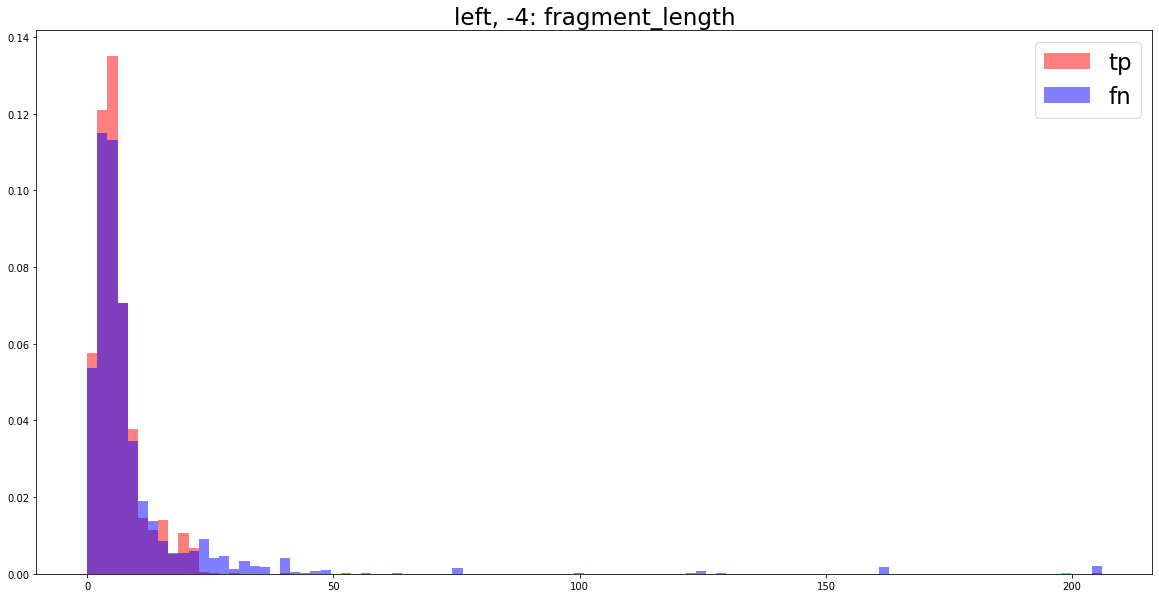

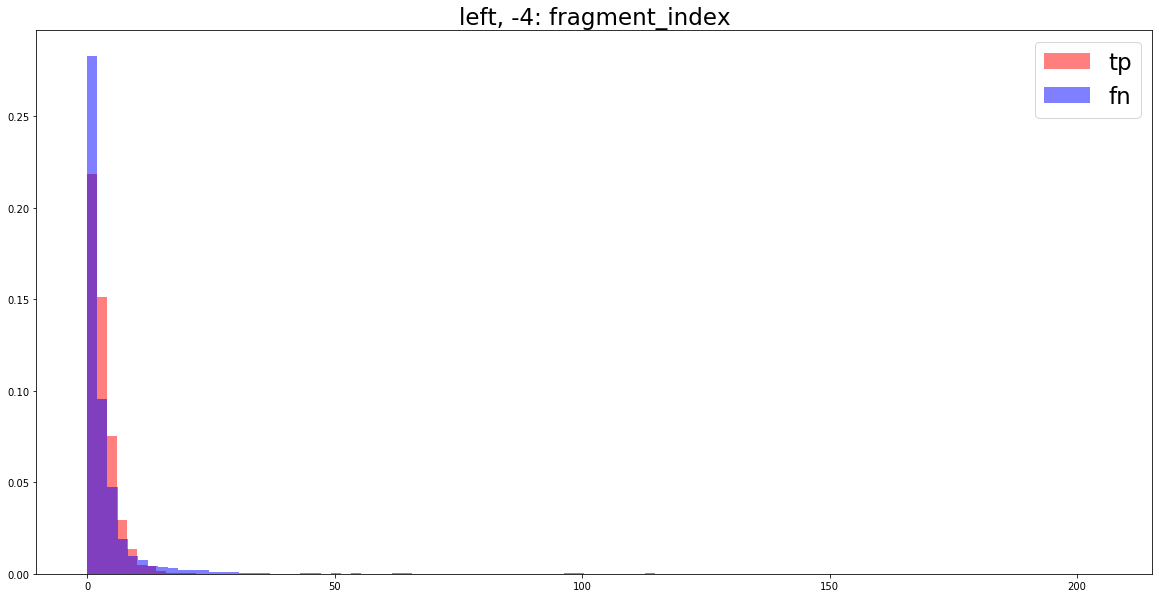

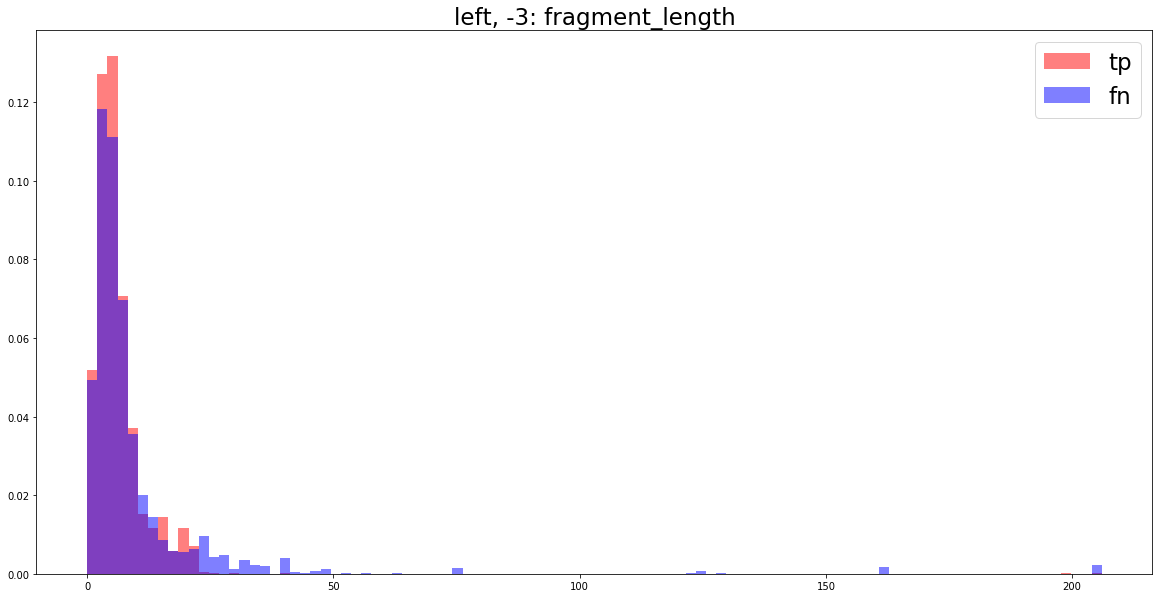

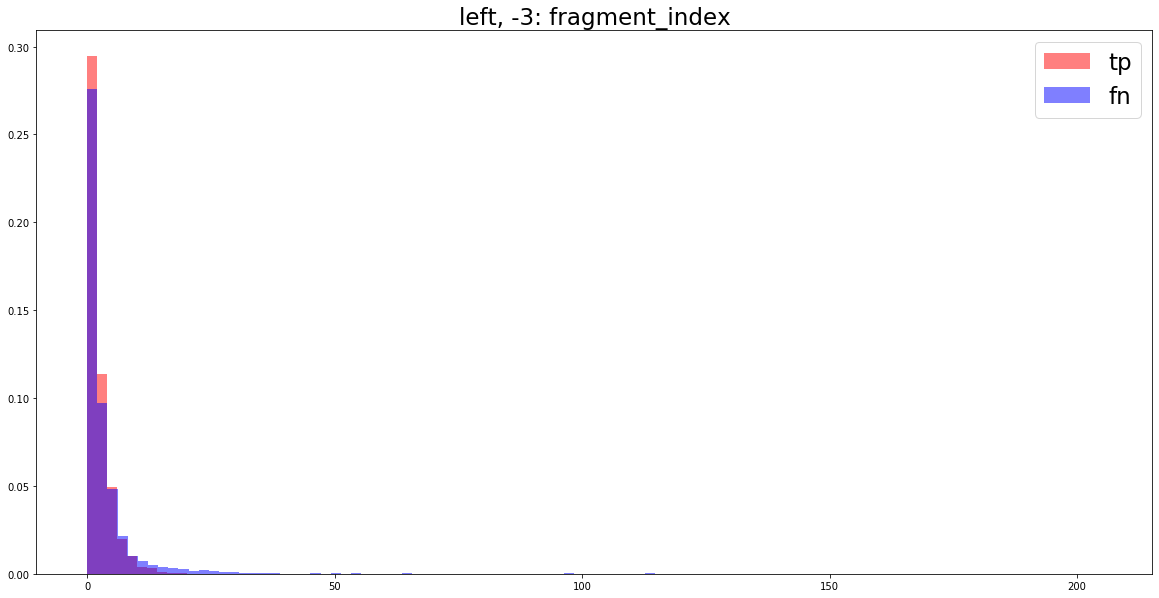

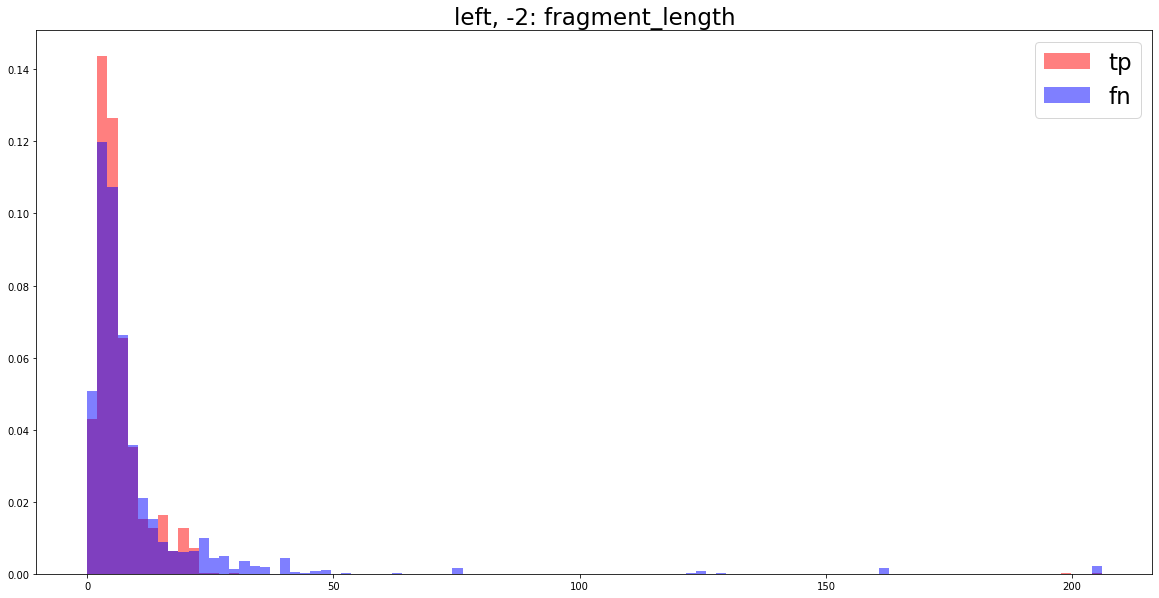

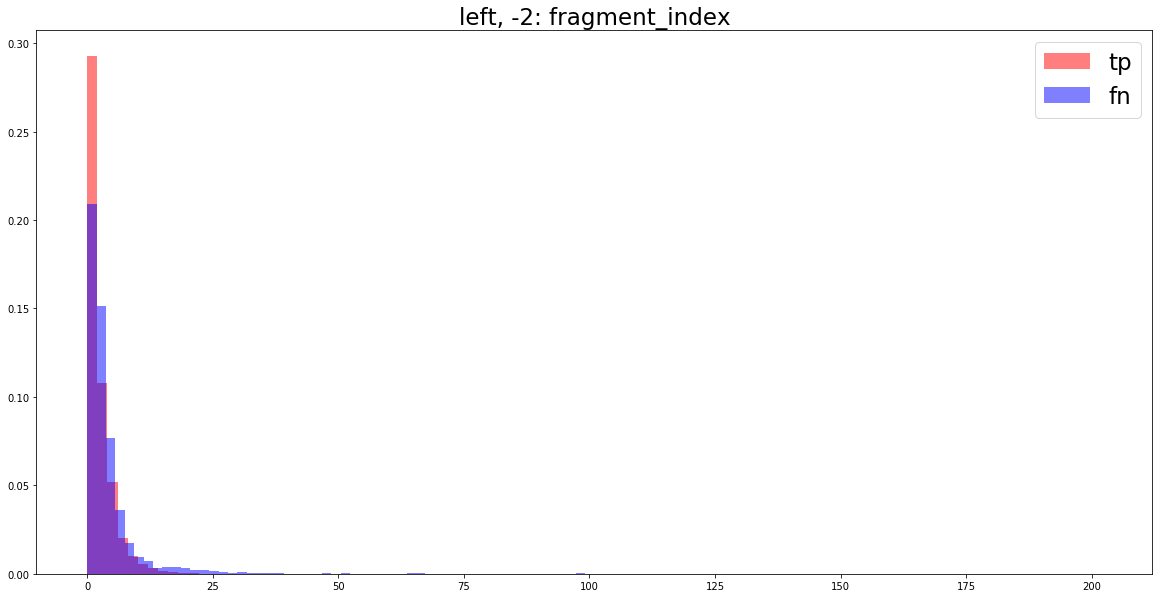

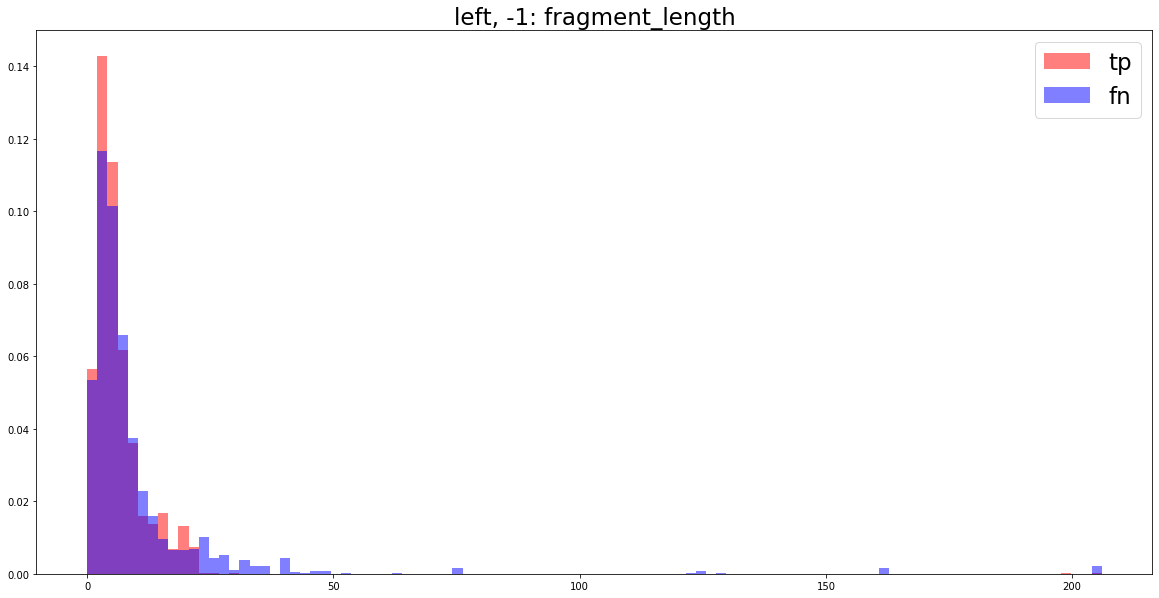

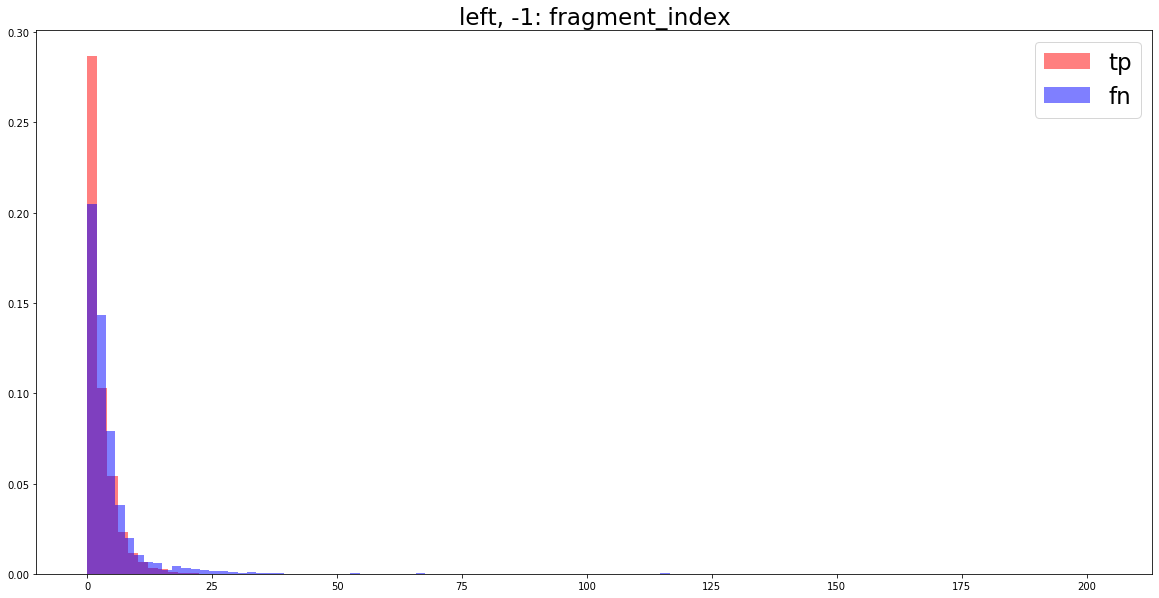

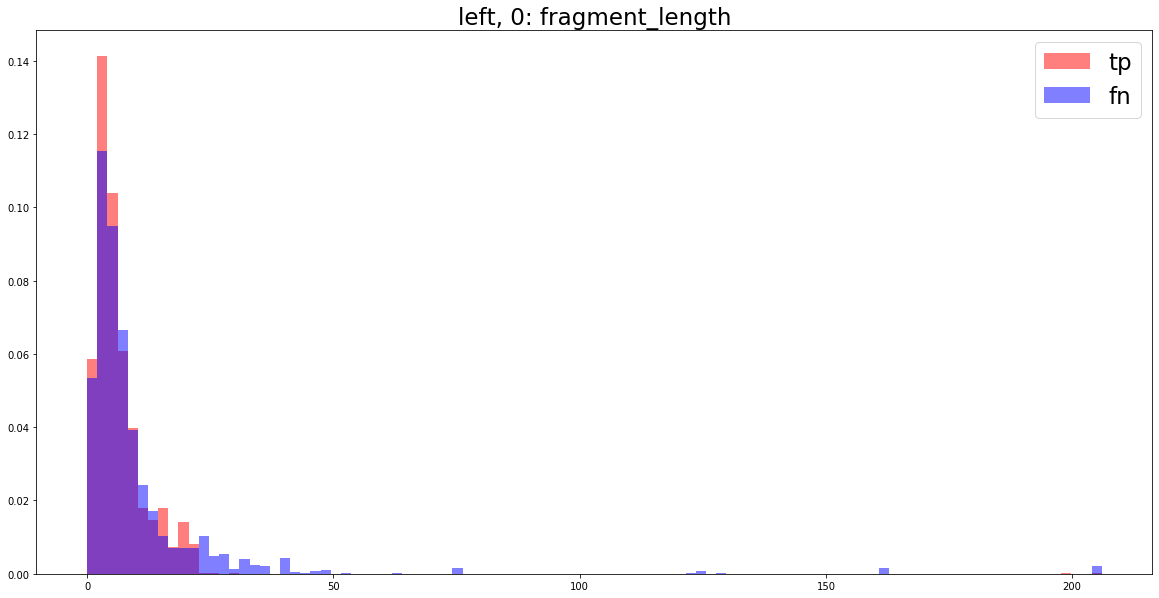

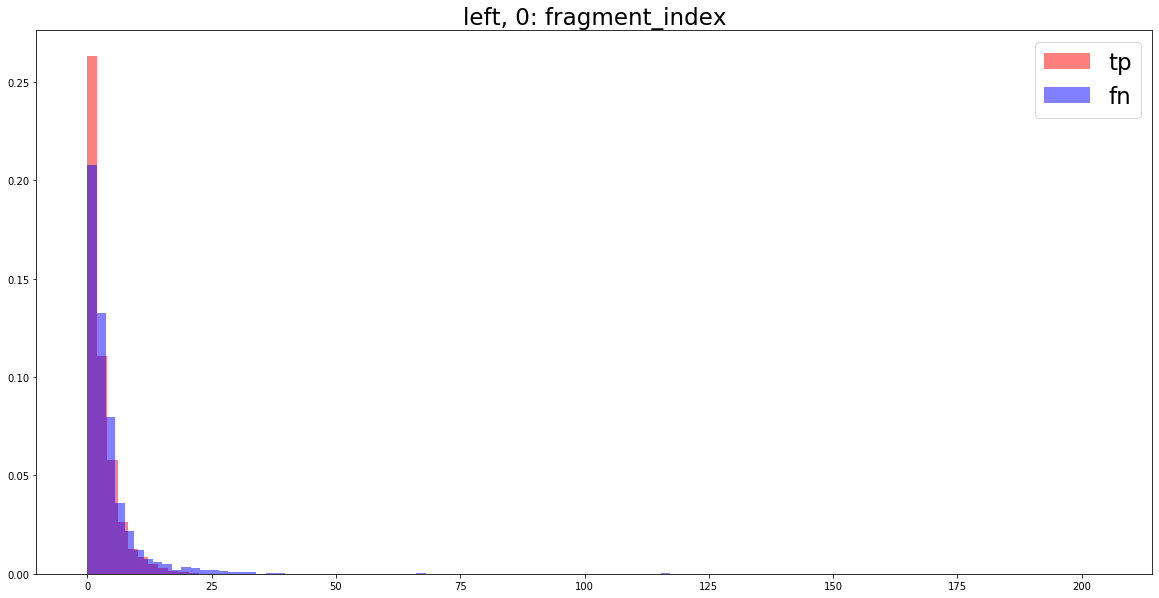

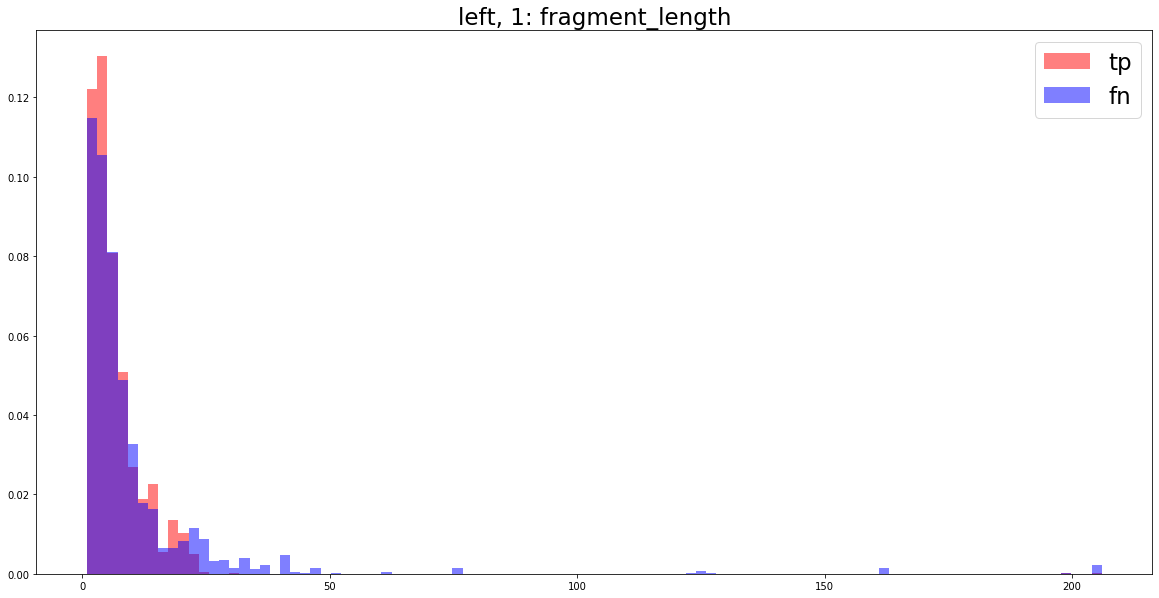

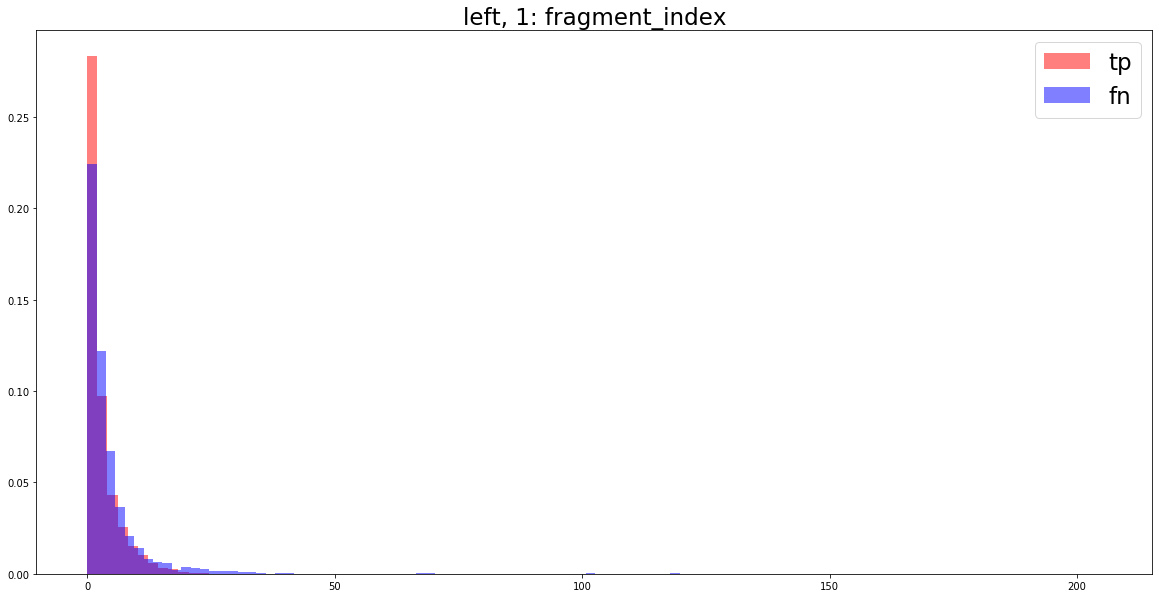

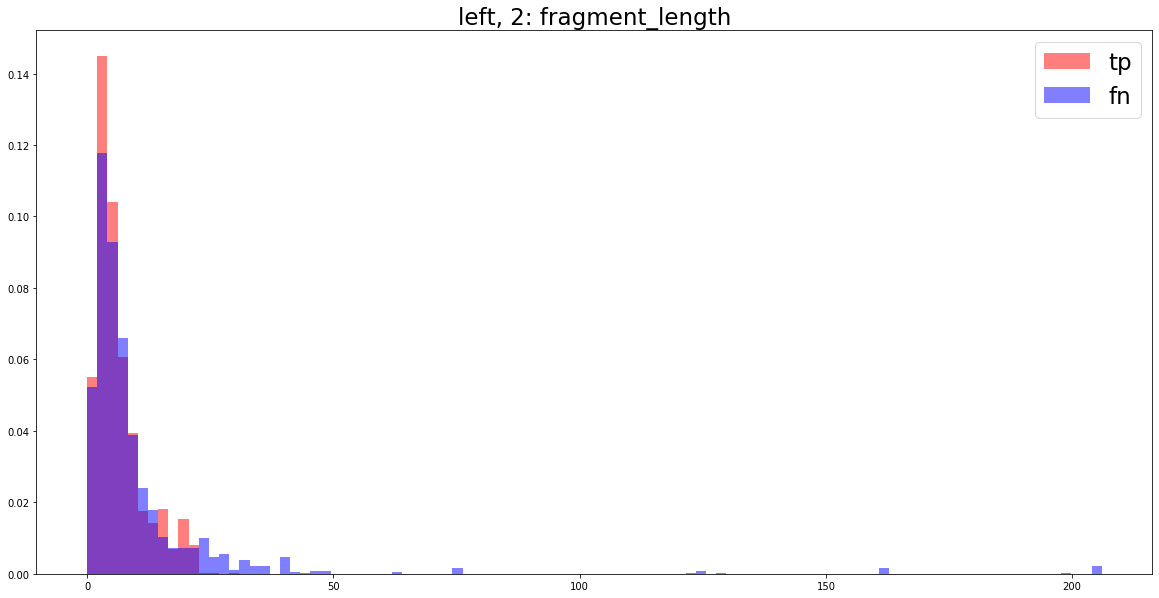

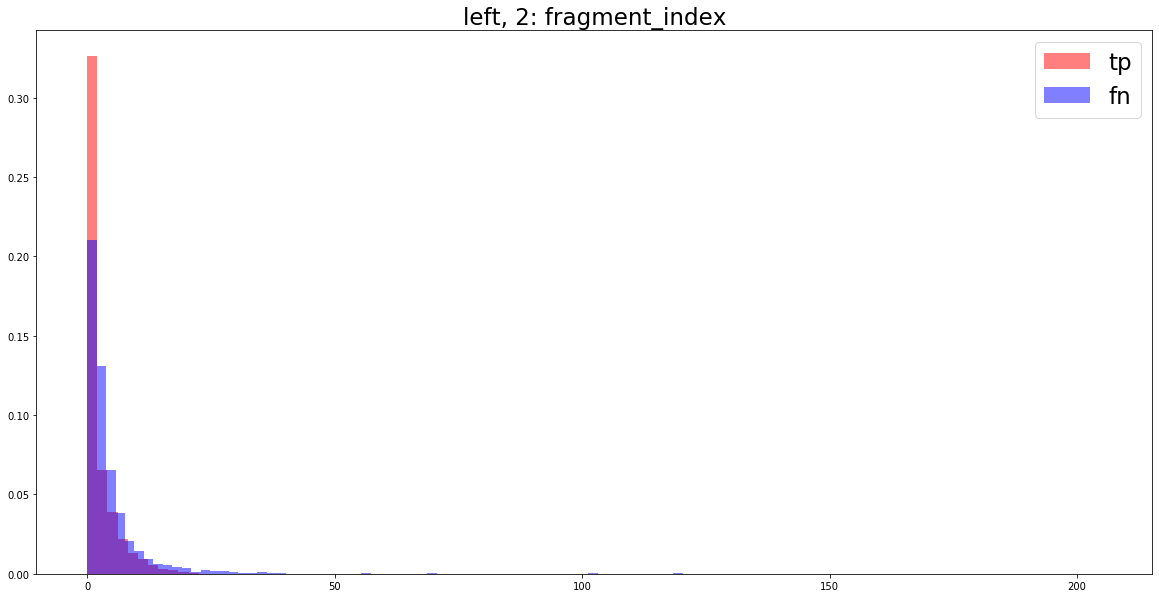

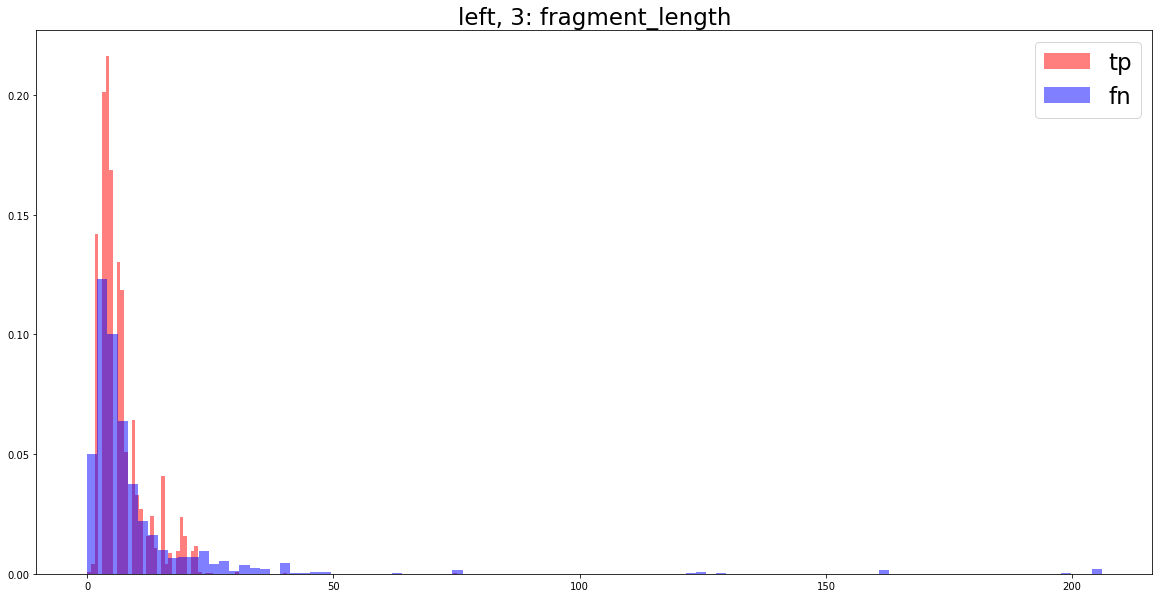

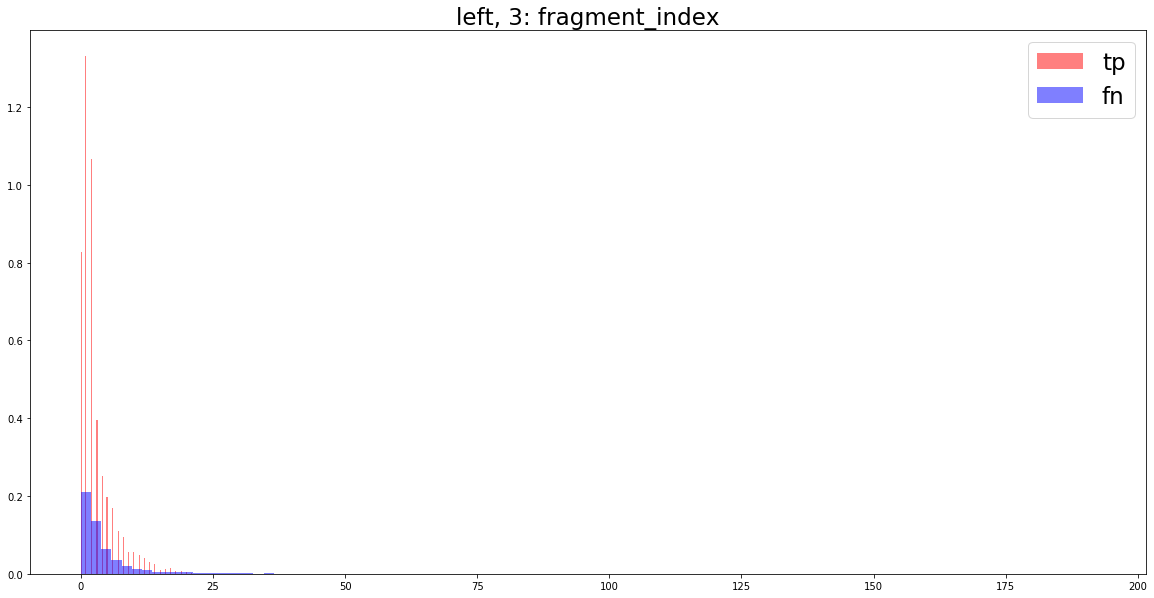

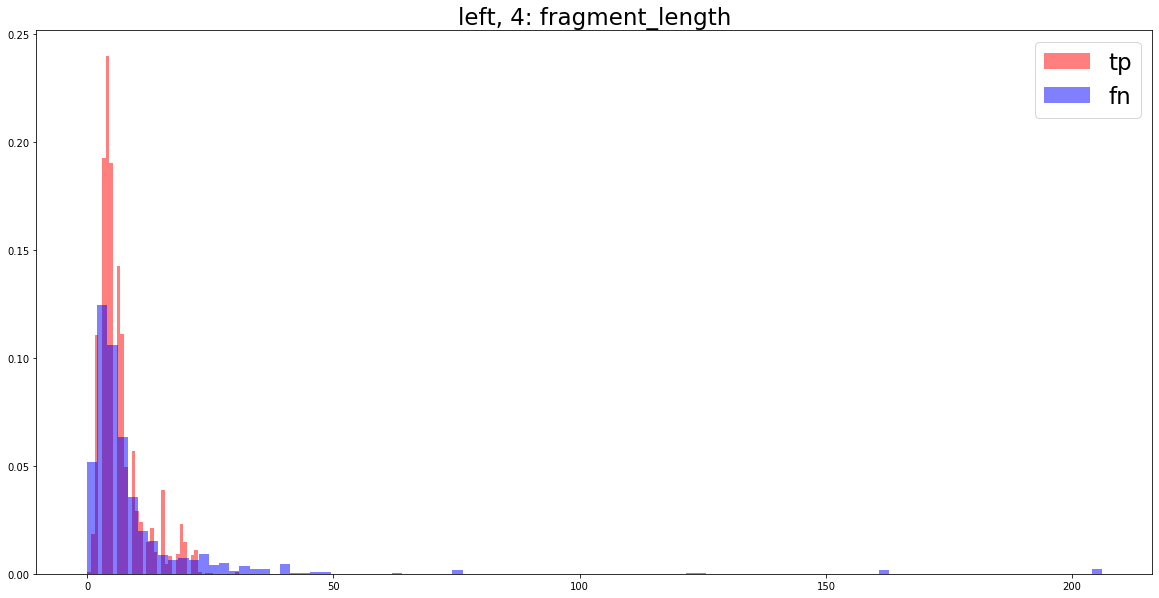

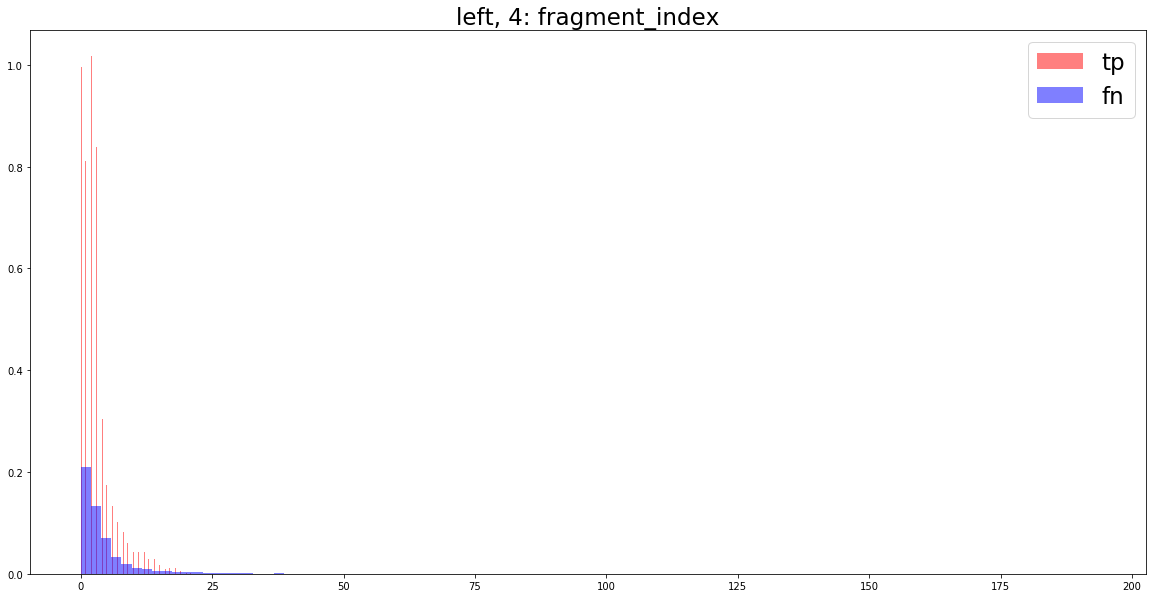

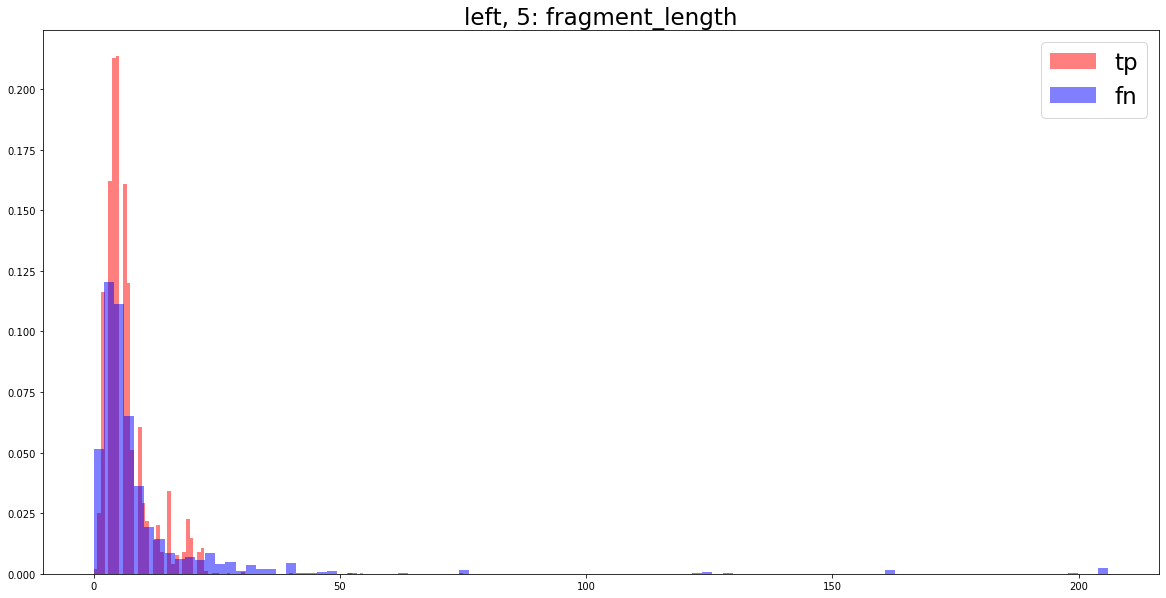

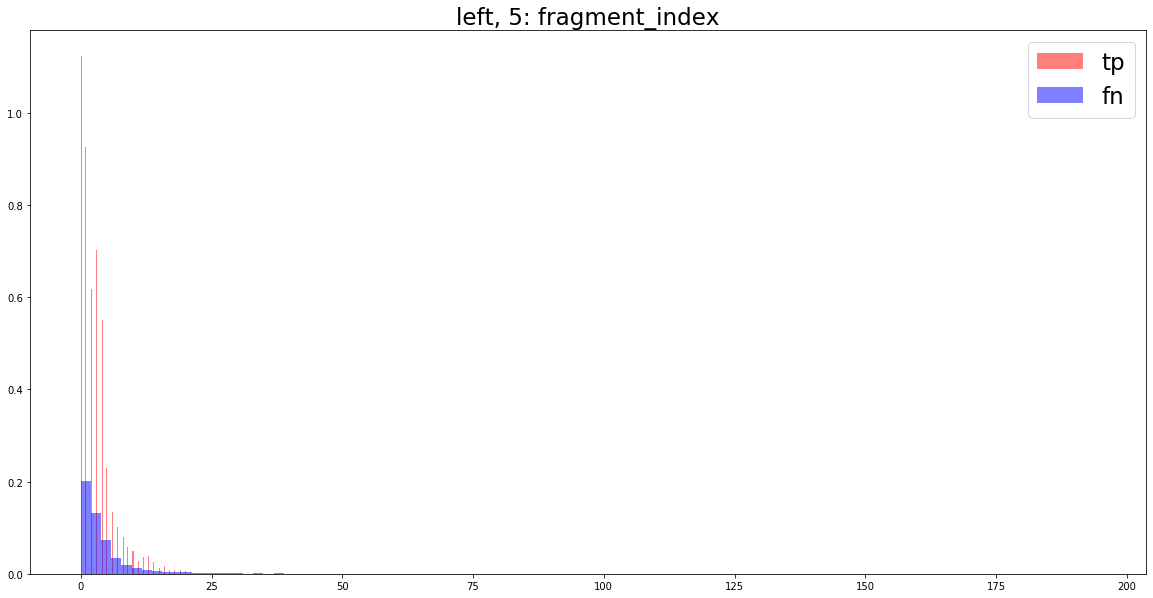

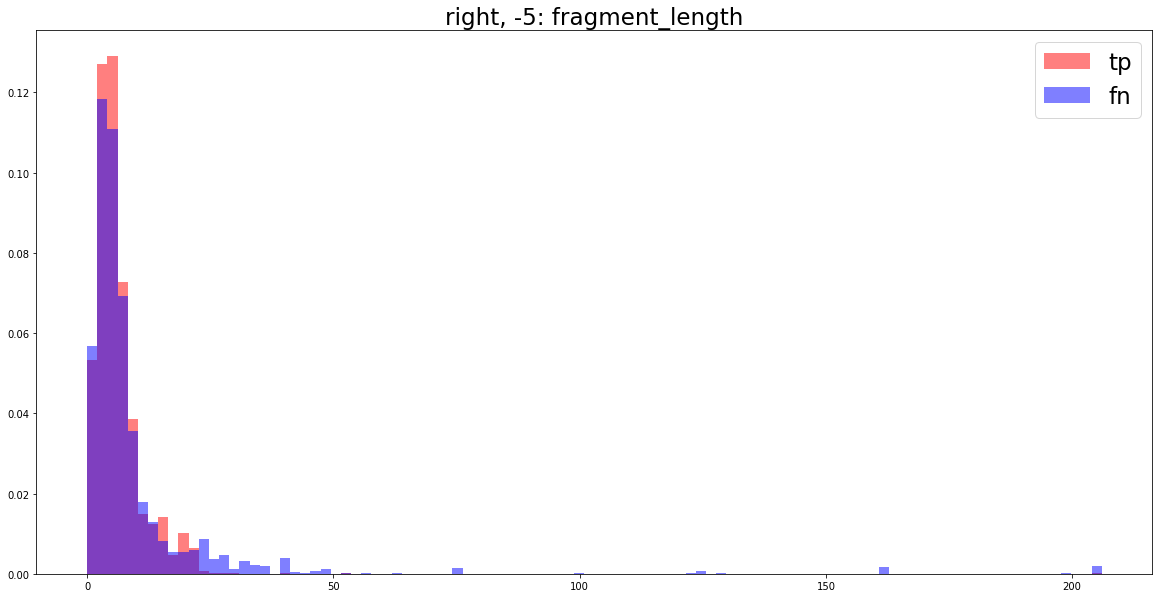

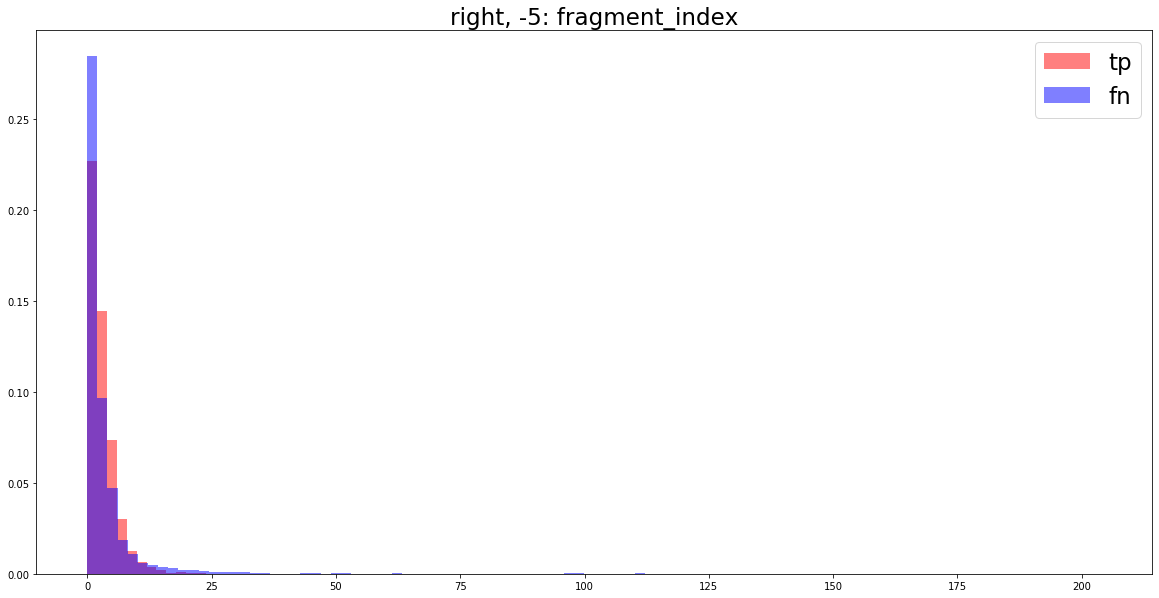

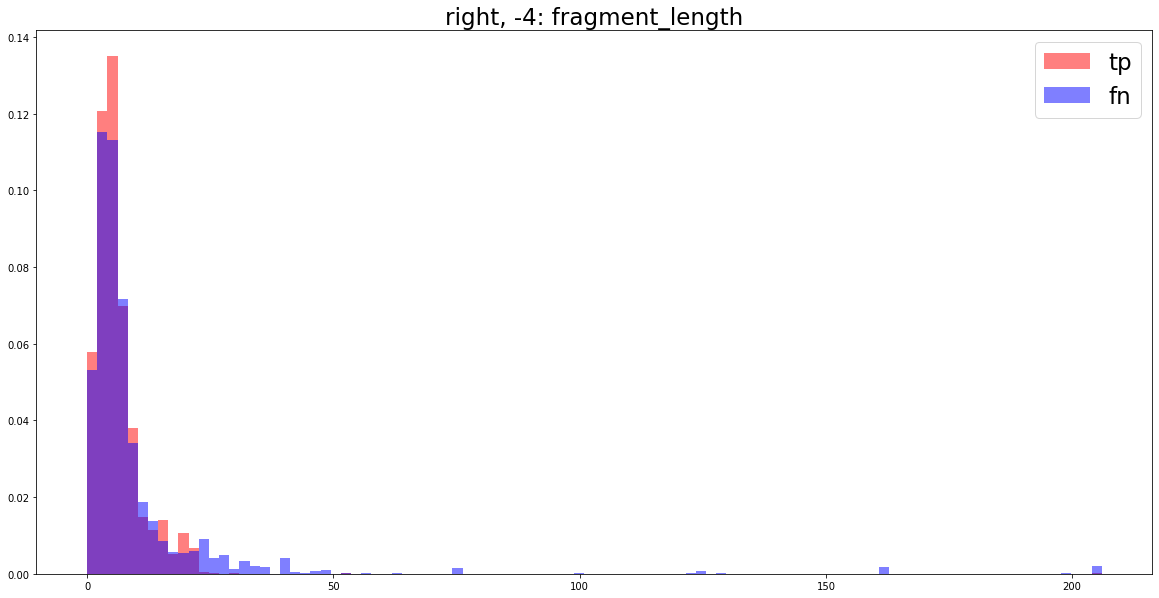

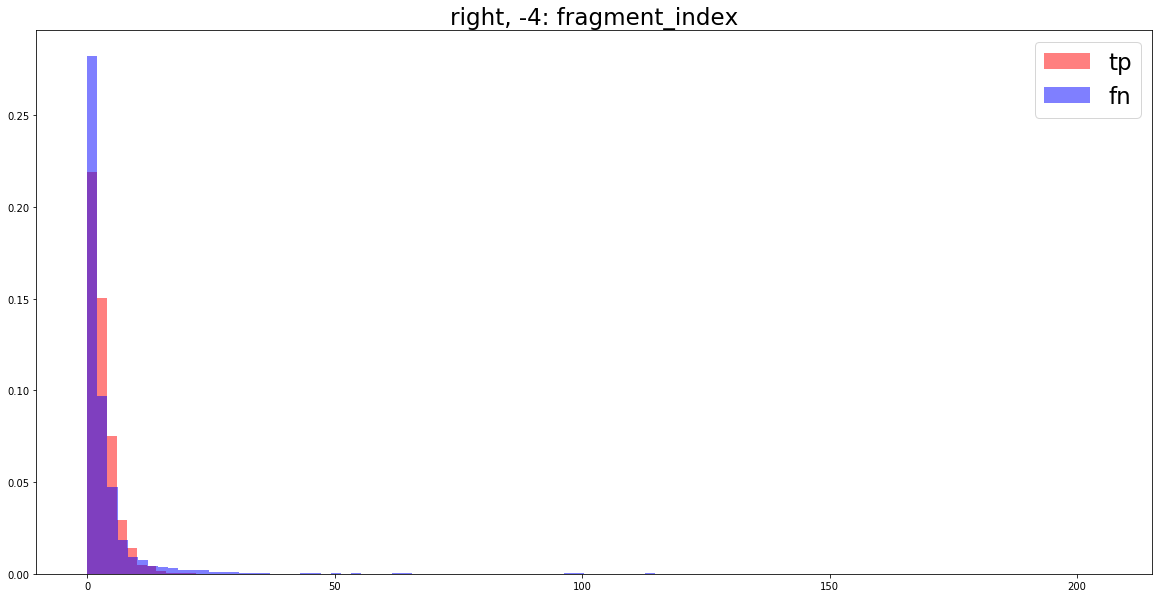

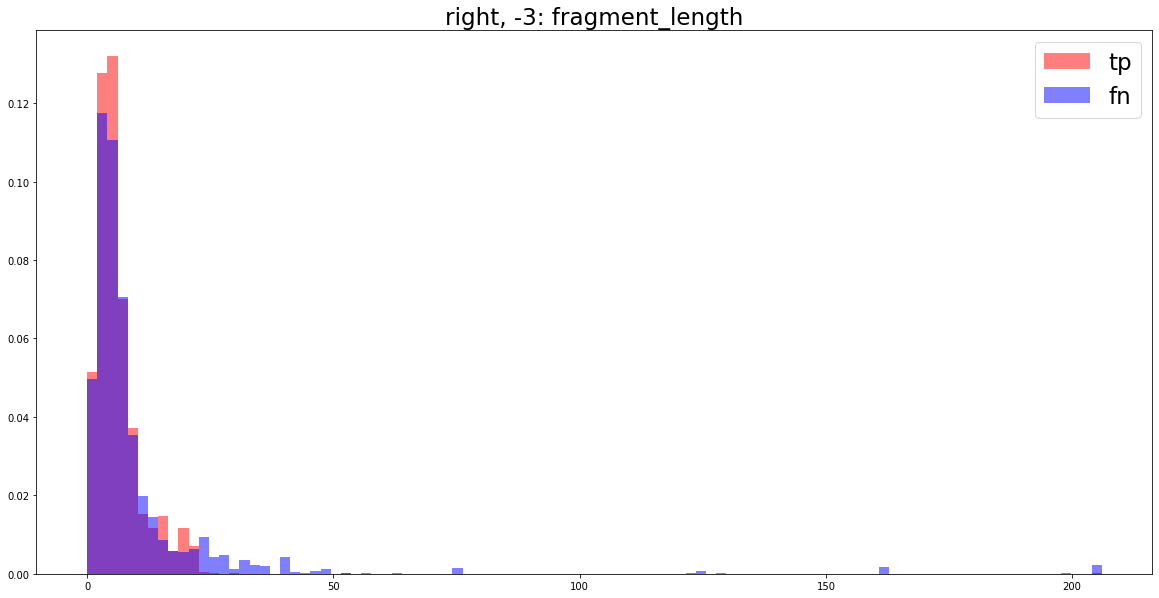

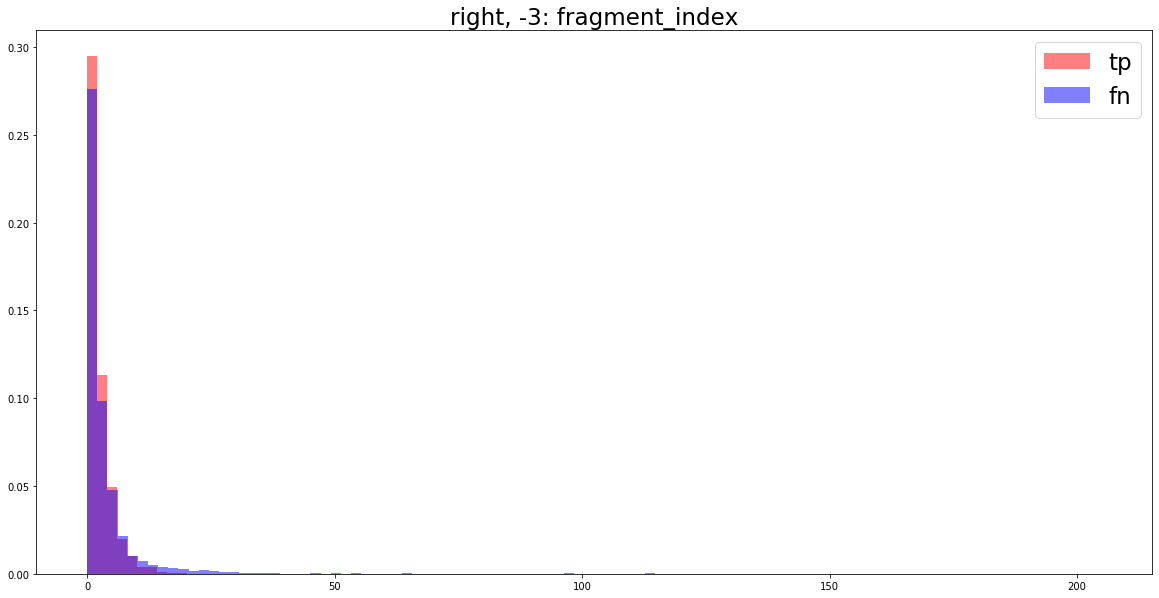

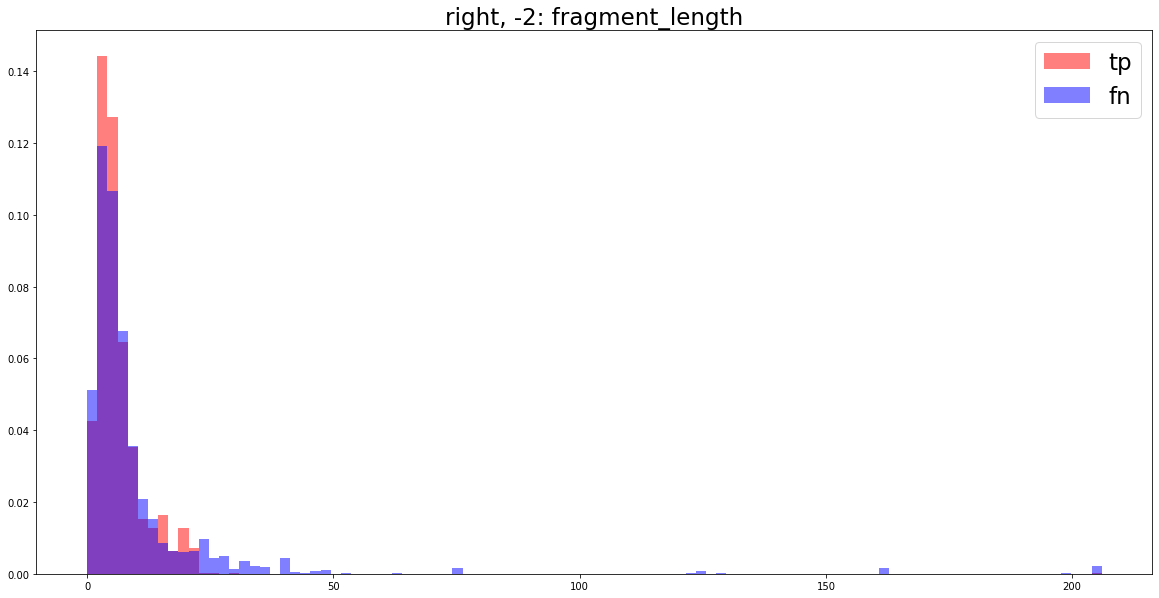

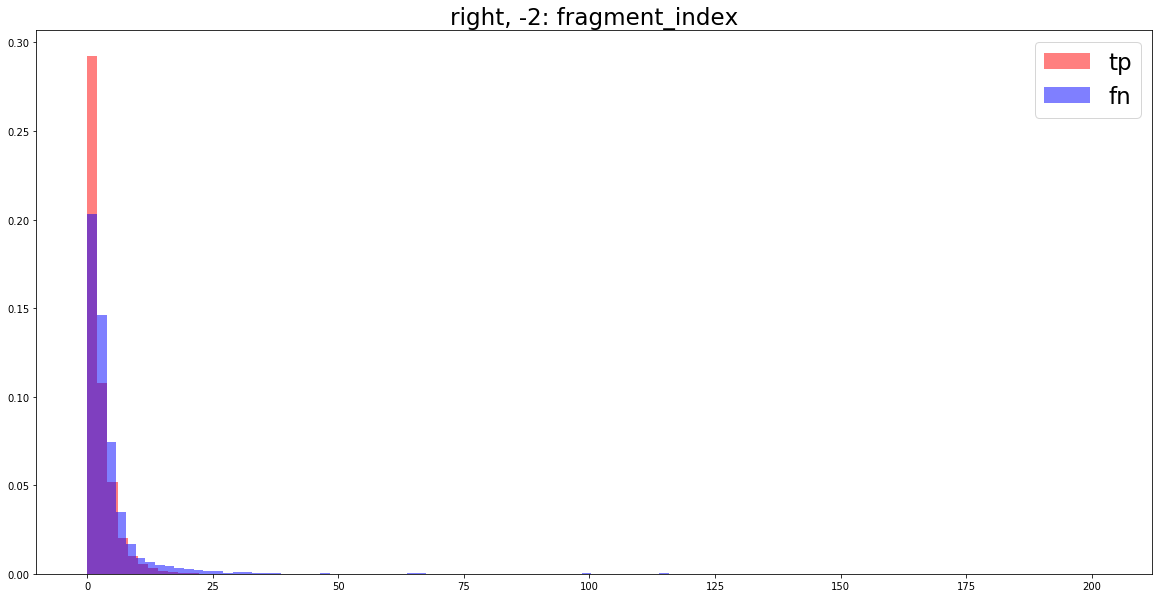

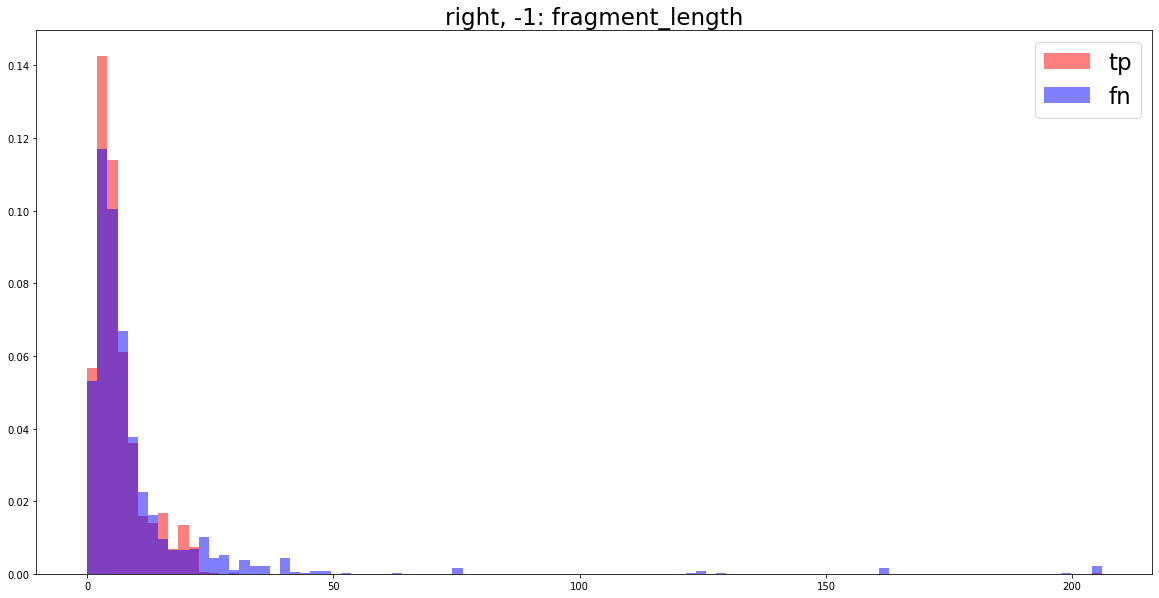

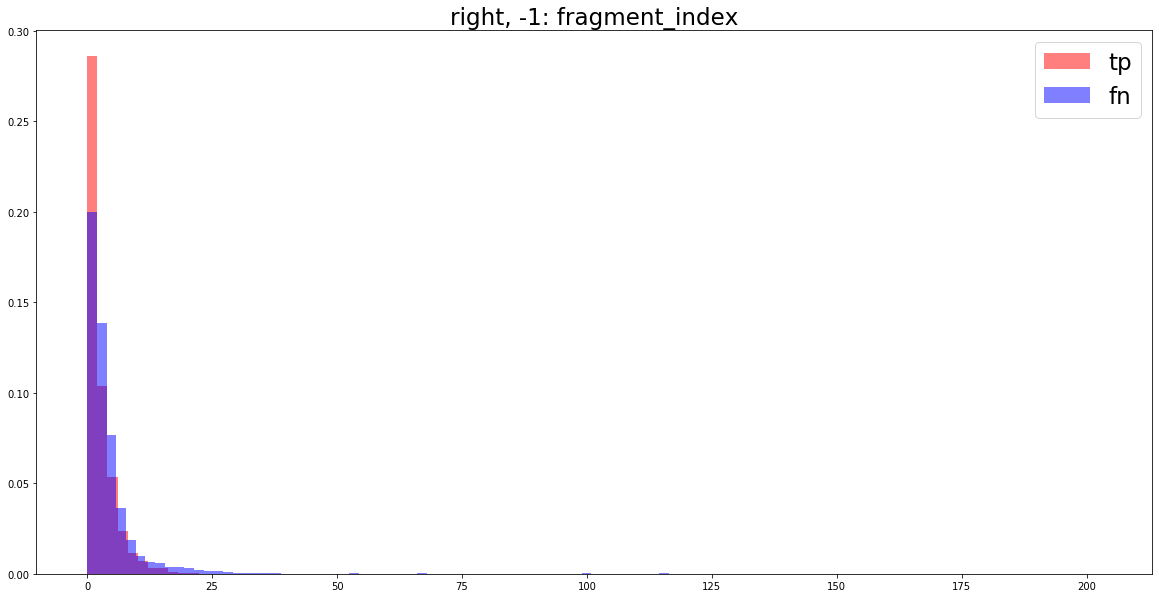

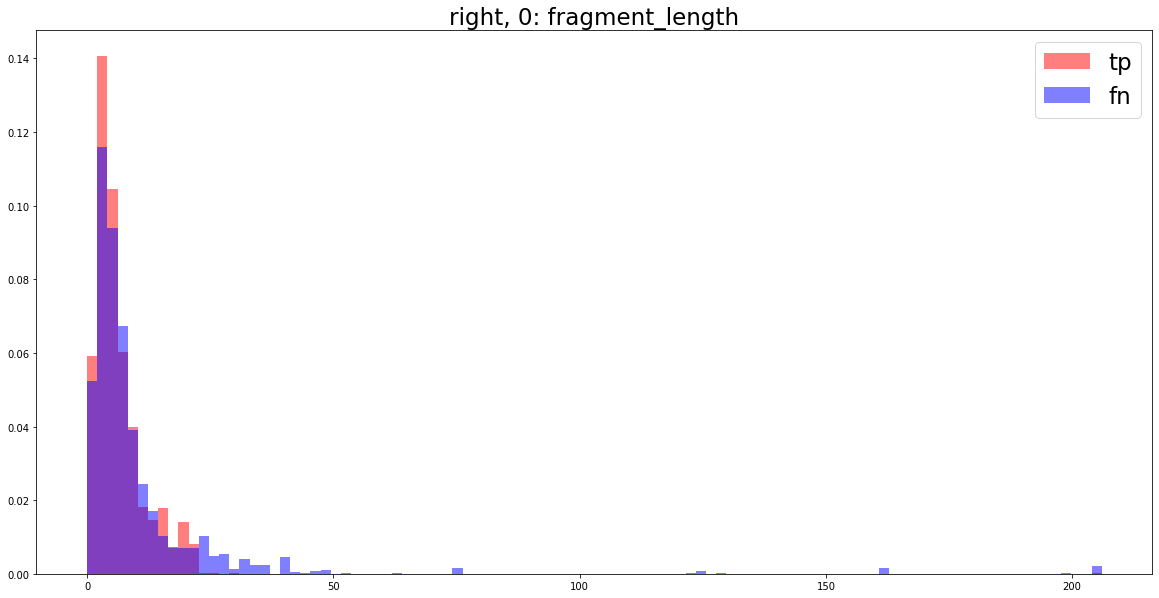

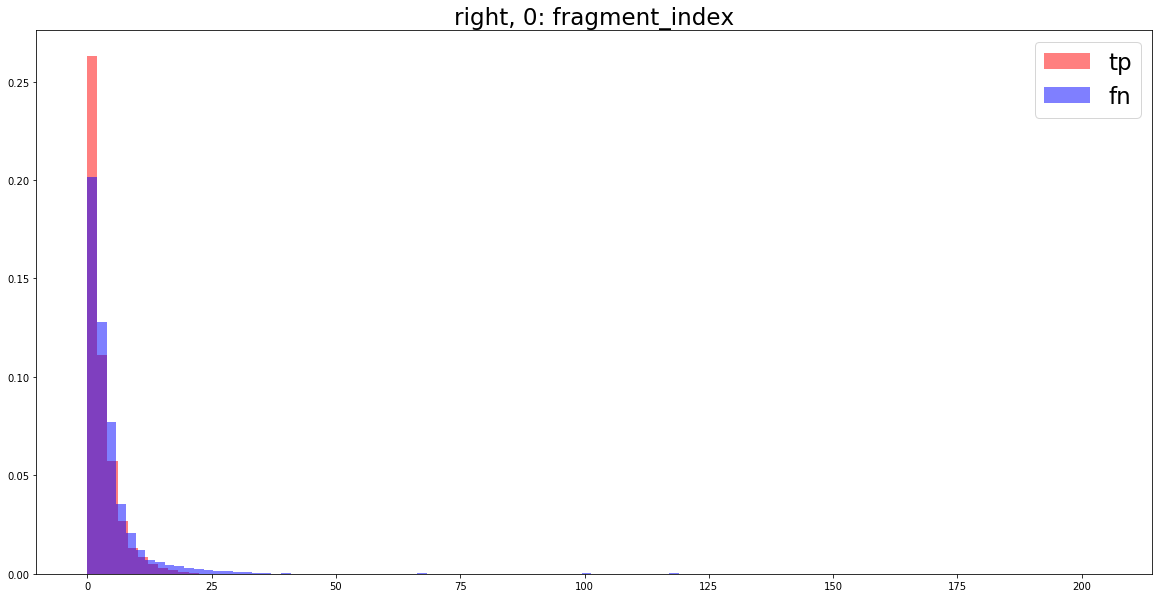

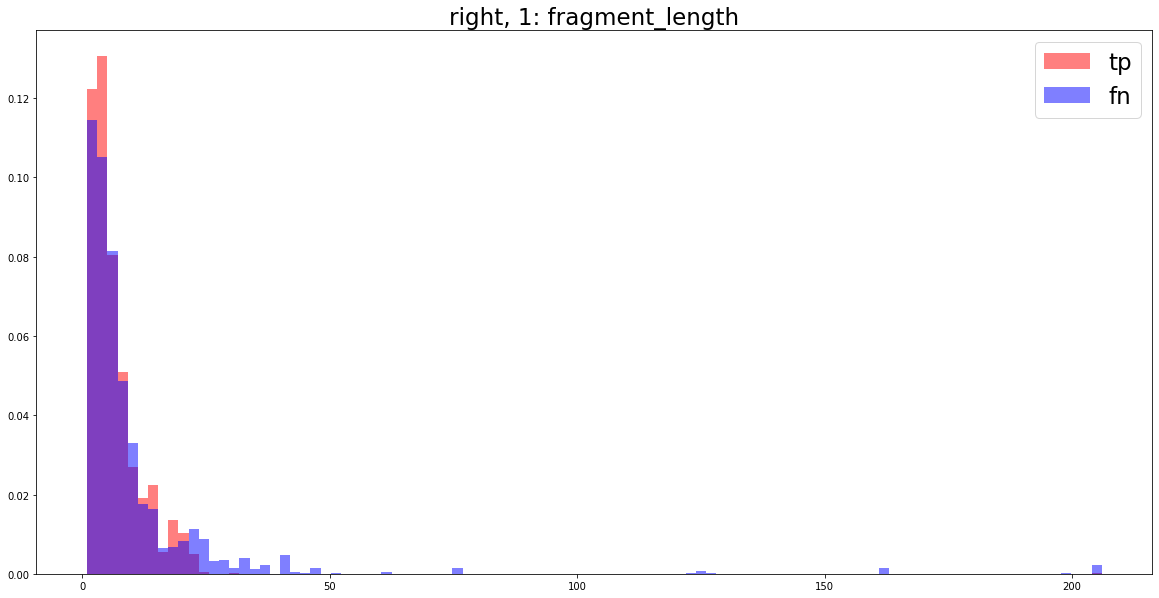

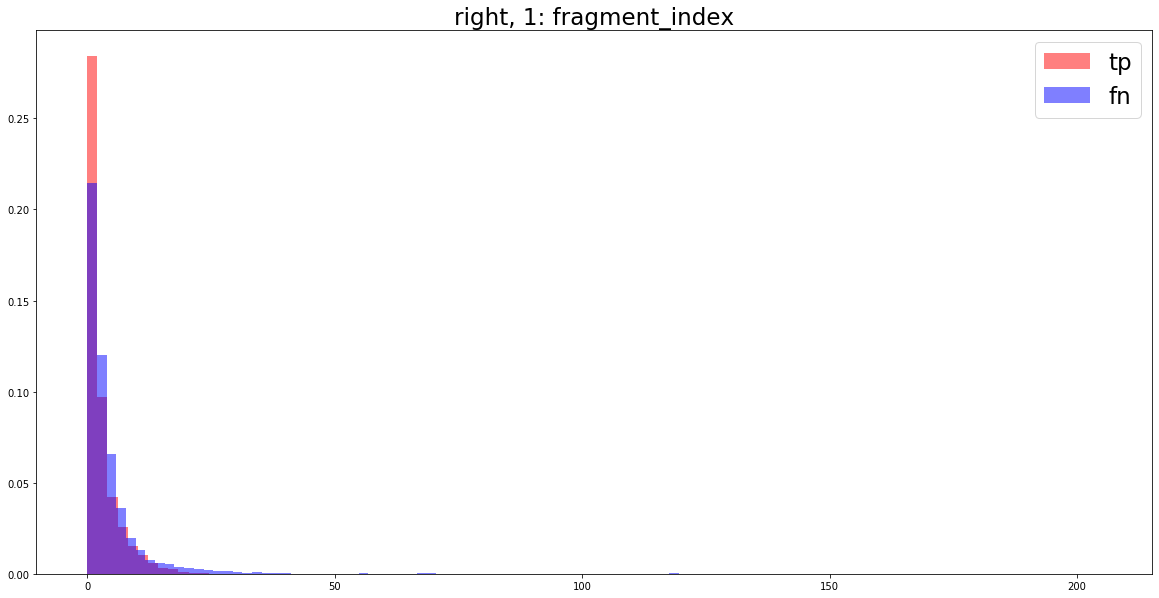

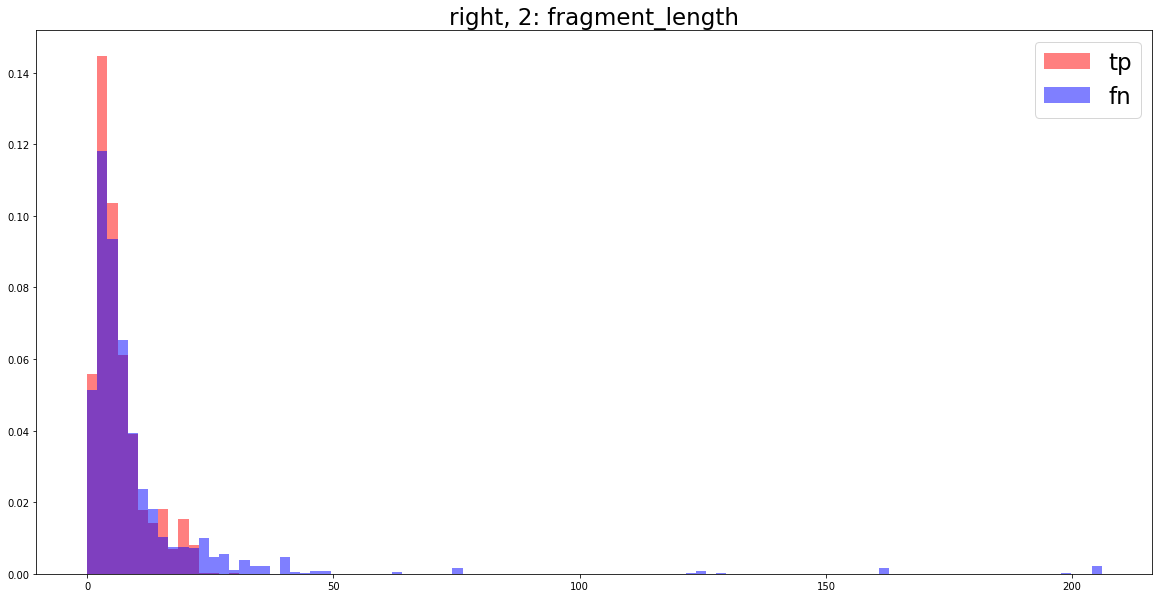

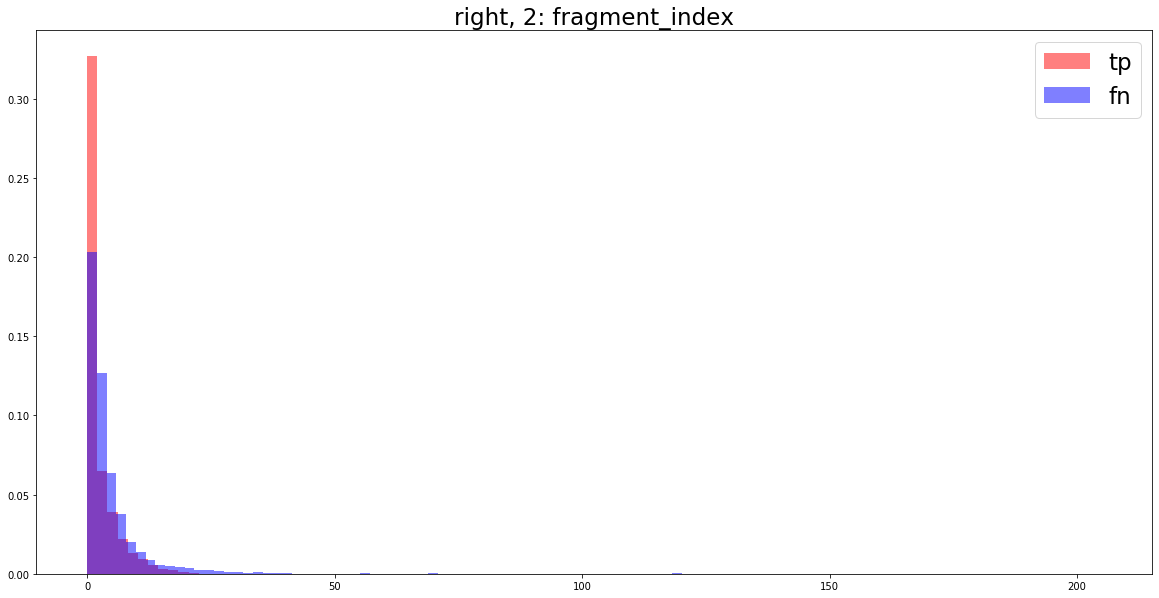

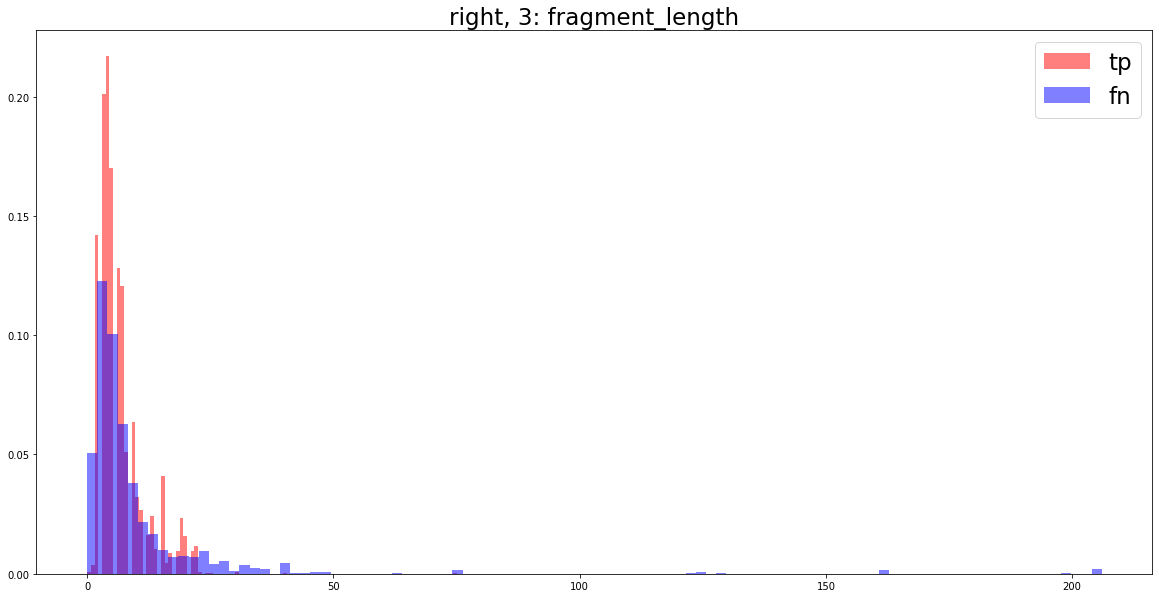

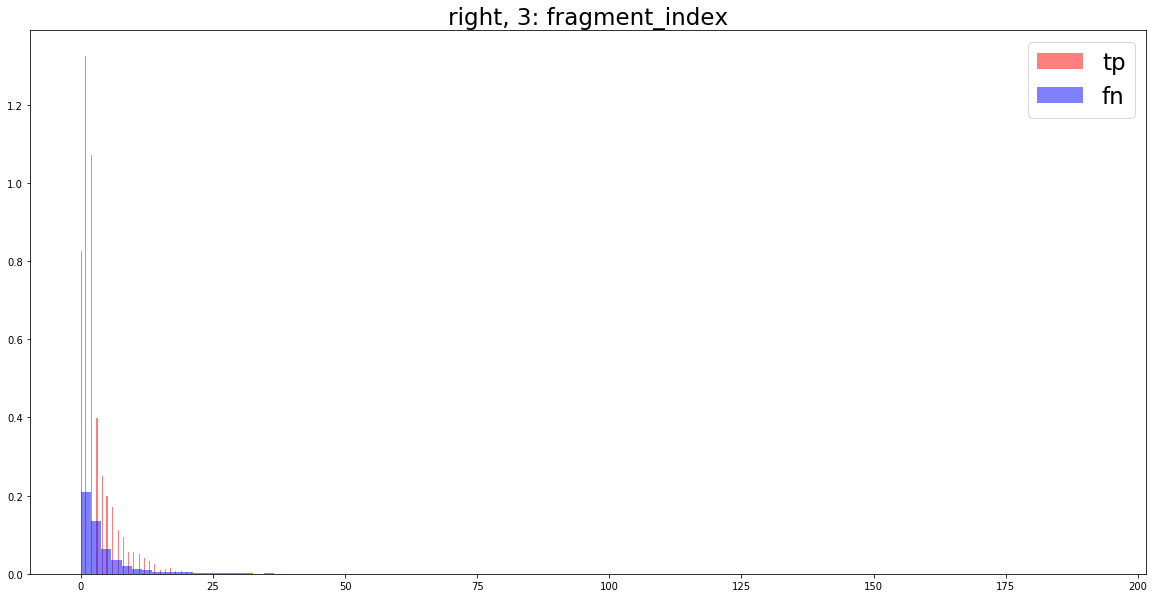

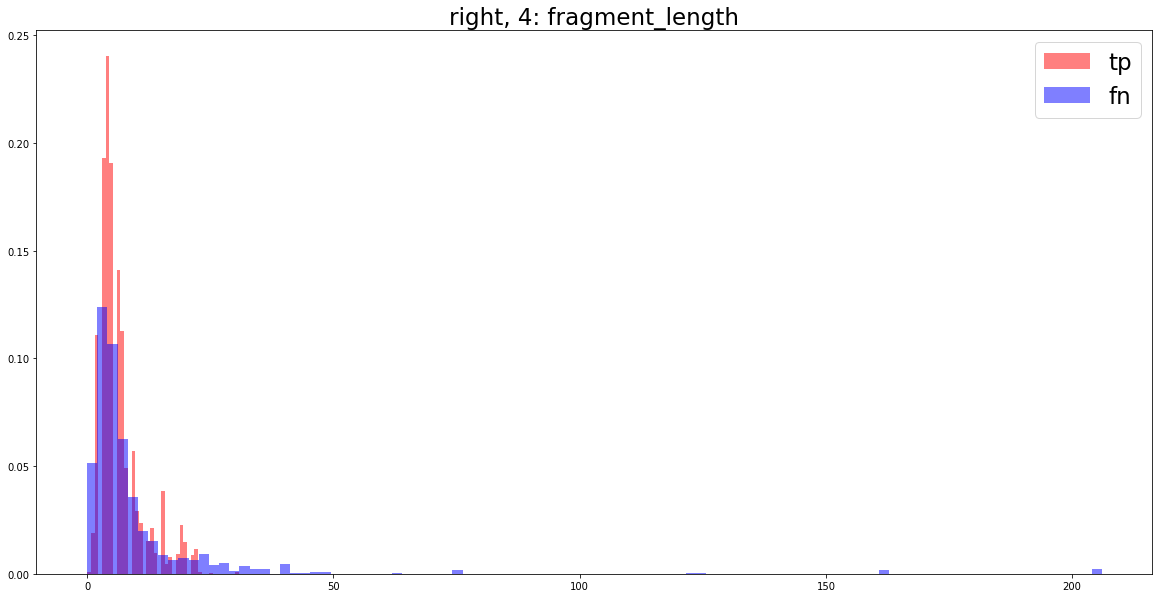

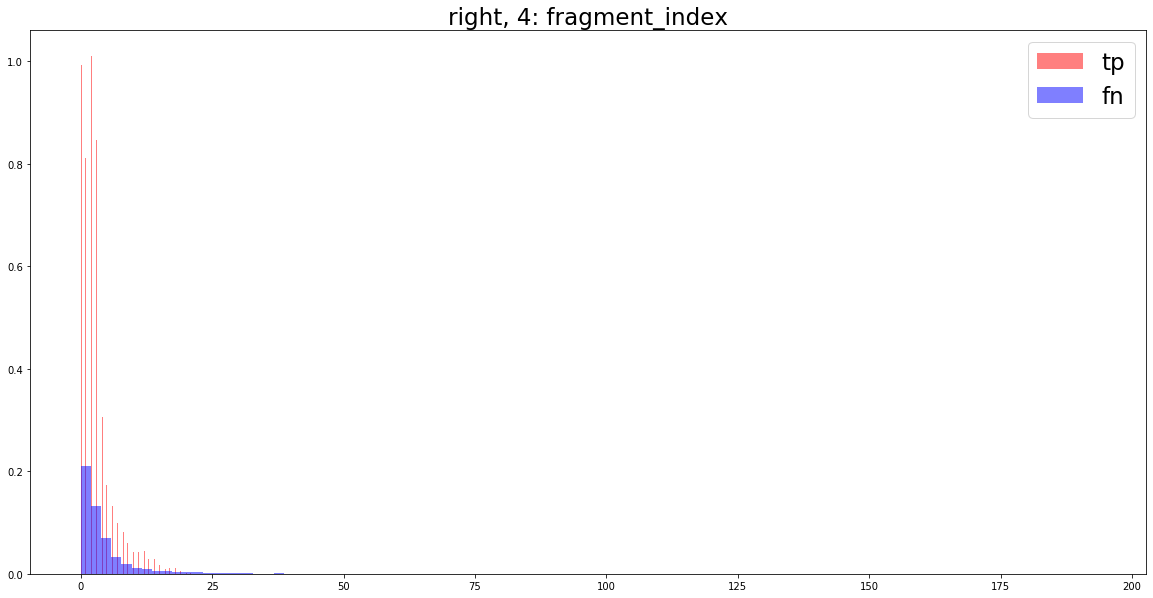

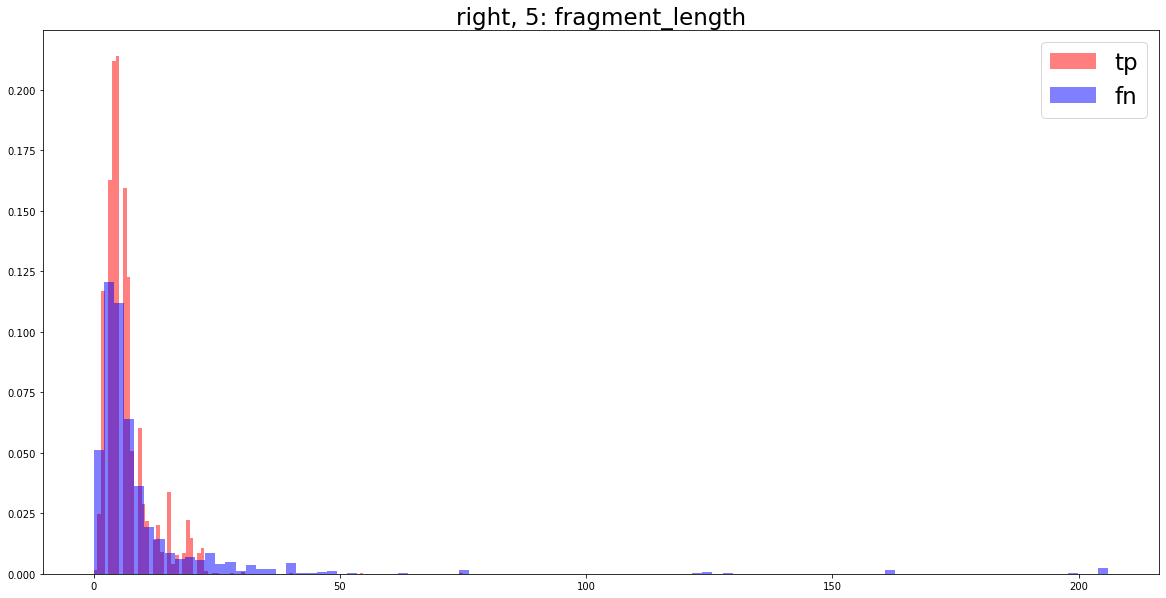

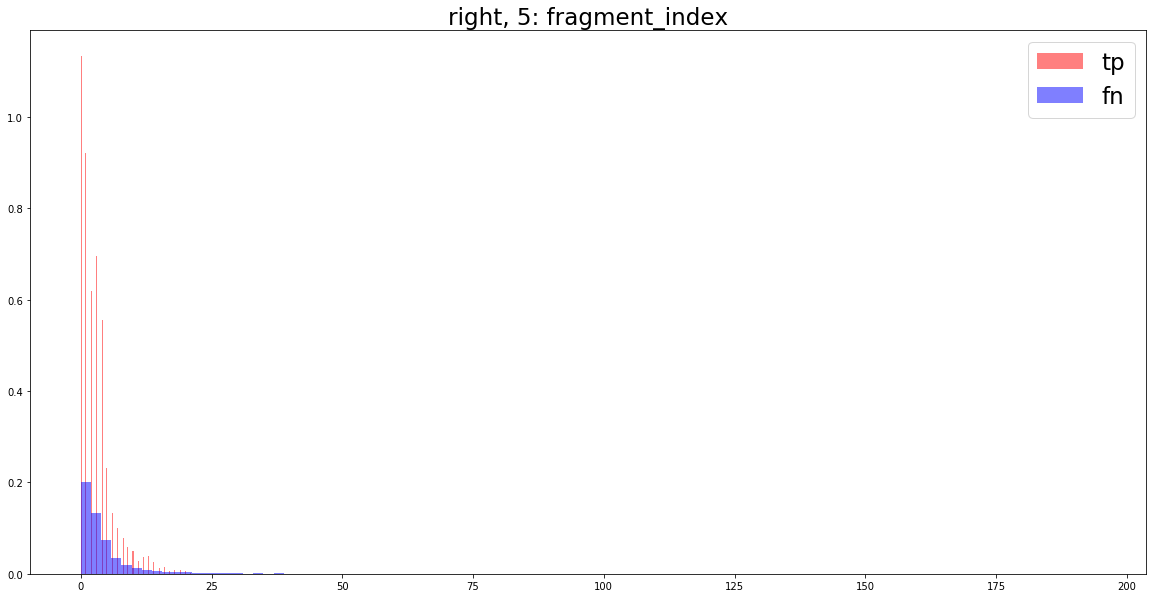

In [95]:
for index in range(22):
    begin = NUCLEOTIDE_FEATURES_LEN * index
    fragment_length_index = begin + FRAGMENT_LENGTH_OFFSET
    fragment_index_index = begin + FRAGMENT_INDEX_OFFSET
    
    title = '{}, {}: {{}}'.format('left' if index < 11 else 'right', (index % 11) - 5)
    
    plt.figure(figsize=(20, 10))
    
    plt.title(title.format('fragment_length'), fontsize=23)
    
    plt.hist(features[true_positive_mask, fragment_length_index], 
             color='r', label='tp', bins=100, alpha=0.5, density=True)
    plt.hist(features[false_negative_mask, fragment_length_index], 
             color='b', label='fn', bins=100, alpha=0.5, density=True)
    
    plt.legend(fontsize=23)
    
    plt.show()
    
    plt.figure(figsize=(20, 10))
    
    plt.title(title.format('fragment_index'), fontsize=23)
    
    plt.hist(features[true_positive_mask, fragment_index_index], 
             color='r', label='tp', bins=100, alpha=0.5, density=True)
    plt.hist(features[false_negative_mask, fragment_index_index], 
             color='b', label='fn', bins=100, alpha=0.5, density=True)
    
    plt.legend(fontsize=23)
    
    plt.show()

Явных отличий я заметить не могу.

Построим график: точки -- цепочки, координаты цепочки -- (precision, recall) в ней. Площадь точки соответствует количеству неканонических спариваний в её цепочке.

In [96]:
points = []

for chain_id in set(chains):
    mask = chains == chain_id
    
    noncanonical_num = (target[mask] == 1).sum()
    
    metrics = precision_recall_fscore_support(target[mask] == 1, new_pred[mask])
    precision = metrics[0][1]
    recall = metrics[1][1]
    
    points.append([precision, recall, noncanonical_num])

In [97]:
precisions, recalls, noncanonical_nums = map(np.array, zip(*points))

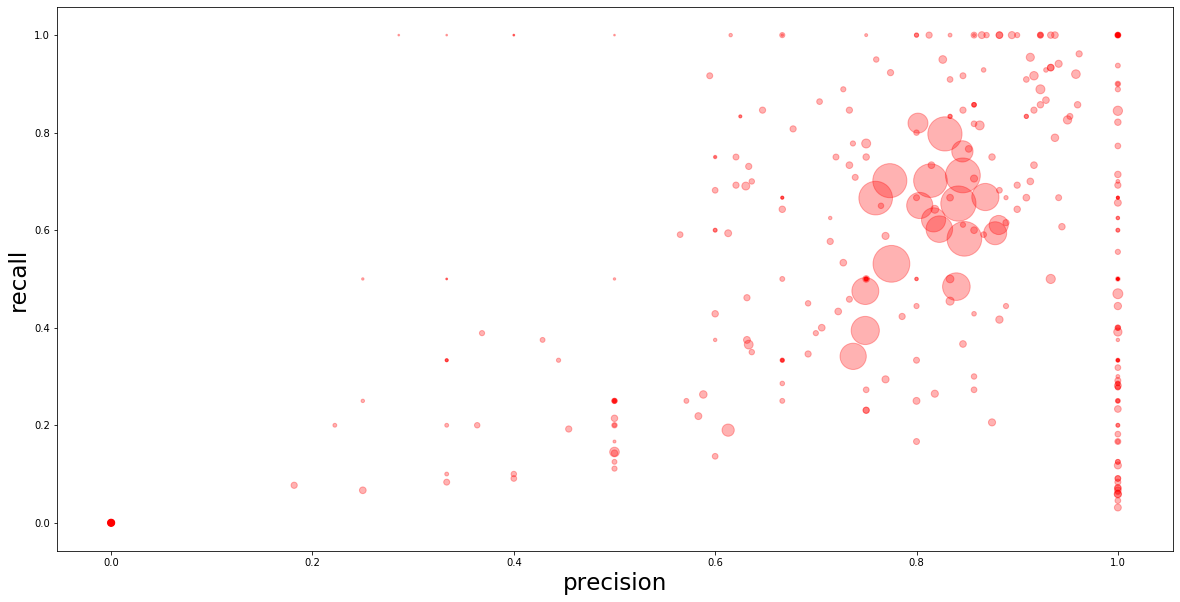

In [98]:
plt.figure(figsize=(20, 10))


plt.xlabel('precision', fontsize=23)
plt.ylabel('recall', fontsize=23)

plt.scatter(precisions, recalls, s=noncanonical_nums * 1.5, alpha=0.3, c='r')

Ситуация такая, какой бы она была, если бы классификация спариваний не зависела от цепочки: в больших цепоках precision/recall -- приблизительно средний по выборке, малые же как-то распределены вокруг. Впрочем стоит обратить внимание на цепочки с нулевым precision/recall.

In [102]:
sum([p[2] for p in points if p[0] == 0 and p[1] == 0]) / sum([p[2] for p in points])

0.03601200400133378

Хотя если их всего 3% они никак не повлияют на итоговые метрики.